# Analisis Mendalam Data Pemesanan Hotel

## Bagian 2: Visualisasi Data dan Insight

Notebook ini berisi visualisasi data pemesanan hotel yang telah diproses pada notebook sebelumnya. Tujuan dari notebook ini adalah untuk menjawab pertanyaan-pertanyaan bisnis penting dan memberikan insight yang dapat digunakan untuk pengambilan keputusan.

## 1. Import Library dan Memuat Data

Pada bagian ini, kita akan mengimpor library yang diperlukan dan memuat data yang telah diproses sebelumnya.

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patches as mpatches
from datetime import datetime
from scipy import stats
import warnings
from matplotlib import gridspec, ticker

# Mengatur tampilan grafik
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Membuat palet warna kustom yang color-blind friendly dan konsisten
# Menggunakan palette yang dioptimalkan untuk visualisasi data dan aksesibilitas
# Dengan gradasi warna yang sesuai untuk categorical data
main_colors = ["#2C7BB6", "#D7191C", "#1A9641", "#FDAE61", "#FFFFBF", "#9E0142", "#A6761D", "#666666"]
main_palette = sns.color_palette(main_colors)
sns.set_palette(main_palette)

# Membuat colormap untuk continuous data
blue_red_cmap = LinearSegmentedColormap.from_list('BlueRed', ["#2C7BB6", "#FFFFBF", "#D7191C"])
blue_green_cmap = LinearSegmentedColormap.from_list('BlueGreen', ["#2C7BB6", "#FFFFBF", "#1A9641"])

# Mengabaikan warning
warnings.filterwarnings('ignore')

In [2]:
# Memuat data yang telah diproses
hotel_df = pd.read_csv('hotel_booking_data/hotel_bookings_processed.csv')

# Mengonversi kolom tanggal kembali ke format datetime jika diperlukan
if 'arrival_date' in hotel_df.columns:
    hotel_df['arrival_date'] = pd.to_datetime(hotel_df['arrival_date'])

# Mengonversi kolom boolean kembali ke format boolean
bool_columns = ['room_type_match', 'has_children', 'has_booking_changes', 'is_direct_booking',
                'is_online_booking', 'room_type_upgrade', 'room_type_downgrade', 'is_domestic']
for col in bool_columns:
    if col in hotel_df.columns:
        hotel_df[col] = hotel_df[col].astype(bool)

# Memeriksa data
print(f"Jumlah baris dalam dataset: {len(hotel_df):,}")

# Memeriksa missing value
missing_values = hotel_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nPeriksa missing value:")
    print(missing_values[missing_values > 0])
else:
    print("\nTidak ada missing value dalam dataset.")

Jumlah baris dalam dataset: 118,727

Tidak ada missing value dalam dataset.


## 2. Fungsi Utilitas untuk Visualisasi

Pada bagian ini, kita akan mendefinisikan beberapa fungsi utilitas yang akan digunakan untuk membuat visualisasi yang konsisten, informatif, dan sesuai dengan best practice.

In [3]:
# Fungsi untuk menambahkan label pada bar chart dengan format yang lebih baik
def add_value_labels(ax, spacing=5, precision=1, percentage=False, fontsize=9, color='black'):
    """
    Menambahkan label nilai di atas bar pada bar chart dengan format yang lebih baik.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes objek yang berisi bar chart
    spacing : int, optional
        Jarak antara bar dan label
    precision : int, optional
        Jumlah angka desimal yang ditampilkan
    percentage : bool, optional
        Apakah nilai ditampilkan sebagai persentase
    fontsize : int, optional
        Ukuran font untuk label
    color : str, optional
        Warna label
    """
    # Untuk setiap bar dalam bar chart
    for rect in ax.patches:
        # Mendapatkan posisi dan tinggi bar
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x() + width / 2
        y = rect.get_y() + height

        # Skip jika height adalah NaN atau terlalu kecil
        if np.isnan(height) or height < 0.01:
            continue

        # Format label berdasarkan precision dan tipe
        if percentage:
            label = f'{height:.{precision}f}%'  # Selalu menampilkan desimal sesuai precision
        elif precision == 0:
            label = f'{int(height):,}'  # Menghilangkan desimal untuk angka bulat
        else:
            label = f'{height:.{precision}f}'  # Selalu menampilkan desimal sesuai precision

        # Menambahkan label
        ax.annotate(
            label,
            xy=(x, y),
            xytext=(0, spacing),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=fontsize,
            fontweight='normal',
            color=color
        )

# Fungsi untuk menambahkan watermark
def add_watermark(fig, text="Analisis Data Hotel Booking", alpha=0.05):
    """
    Menambahkan watermark pada figure.

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        Figure objek yang akan ditambahkan watermark
    text : str, optional
        Teks watermark
    alpha : float, optional
        Transparansi watermark
    """
    # Menambahkan watermark
    fig.text(
        0.5, 0.5,
        text,
        fontsize=40,
        color='gray',
        ha='center',
        va='center',
        alpha=alpha,
        rotation=30
    )

# Fungsi untuk menambahkan judul dan caption
def add_title_and_caption(fig, title, subtitle=None, caption=None):
    """
    Menambahkan judul, subtitle dan caption pada figure.

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        Figure objek yang akan ditambahkan judul dan caption
    title : str
        Judul visualisasi
    subtitle : str, optional
        Subtitle visualisasi
    caption : str, optional
        Caption visualisasi
    """
    # Menambahkan judul
    fig.suptitle(
        title,
        fontsize=16,
        fontweight='bold',
        y=0.98
    )

    # Menambahkan subtitle jika ada
    if subtitle:
        fig.text(
            0.5, 0.94,
            subtitle,
            fontsize=12,
            ha='center',
            va='top',
            style='italic'
        )

    # Menambahkan caption jika ada
    if caption:
        fig.text(
            0.5, 0.01,
            caption,
            fontsize=10,
            ha='center',
            va='bottom',
            style='italic'
        )

# Fungsi untuk menggabungkan kategori kecil menjadi "Others"
def combine_small_categories(series, threshold=0.05, name='Others'):
    """
    Menggabungkan kategori dengan proporsi kecil menjadi 'Others'.

    Parameters:
    -----------
    series : pandas.Series
        Series yang berisi count data kategorikal
    threshold : float, optional
        Ambang batas proporsi untuk kategori yang akan digabungkan
    name : str, optional
        Nama untuk kategori gabungan

    Returns:
    --------
    pandas.Series
        Series baru dengan kategori kecil digabungkan
    """
    # Mengkonversi ke proporsi
    proportions = series / series.sum()

    # Mengidentifikasi kategori kecil
    small_cats = proportions[proportions < threshold].index

    # Jika tidak ada kategori kecil, kembalikan series asli
    if len(small_cats) == 0:
        return series

    # Membuat series baru dengan kategori kecil digabungkan
    new_series = series.copy()
    new_series.loc[name] = series[small_cats].sum()
    new_series = new_series.drop(small_cats)

    # Mengurutkan dari terbesar ke terkecil, dengan 'Others' di akhir
    new_series = new_series.sort_values(ascending=False)
    if name in new_series:
        others_value = new_series.loc[name]
        new_series = new_series.drop(name)
        new_series.loc[name] = others_value

    return new_series

# Fungsi untuk membuat bar chart horizontal dengan warna yang disesuaikan dengan nilai
def create_horizontal_bar_chart(data, title, xlabel, ylabel, cmap=None, figsize=(12, 8),
                               add_labels=True, percentage=False, precision=1, ax=None,
                               threshold=None, ascending=True):
    """
    Membuat bar chart horizontal dengan gradasi warna.

    Parameters:
    -----------
    data : pandas.Series
        Data yang akan divisualisasikan
    title : str
        Judul grafik
    xlabel : str
        Label sumbu x
    ylabel : str
        Label sumbu y
    cmap : matplotlib.colors.Colormap, optional
        Colormap untuk gradasi warna
    figsize : tuple, optional
        Ukuran figure
    add_labels : bool, optional
        Apakah menambahkan label nilai
    percentage : bool, optional
        Apakah data dalam bentuk persentase
    precision : int, optional
        Jumlah angka desimal untuk label
    ax : matplotlib.axes.Axes, optional
        Axes objek untuk plotting
    threshold : float, optional
        Threshold untuk highlight bar
    ascending : bool, optional
        Urutan data (ascending atau descending)

    Returns:
    --------
    matplotlib.axes.Axes
        Axes objek yang berisi bar chart
    """
    # Mengurutkan data
    data = data.sort_values(ascending=ascending)

    # Membuat figure dan axes jika tidak diberikan
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Menetapkan colormap default jika tidak diberikan
    if cmap is None:
        cmap = blue_red_cmap if not ascending else blue_green_cmap

    # Membuat norm untuk memetakan nilai ke warna
    norm = plt.Normalize(data.min(), data.max())

    # Membuat bar chart
    bars = ax.barh(data.index, data.values, color=[cmap(norm(x)) for x in data.values])

    # Menambahkan label nilai jika diminta
    if add_labels:
        # Untuk setiap bar
        for i, bar in enumerate(bars):
            width = bar.get_width()
            label_x_pos = width

            # Format label berdasarkan tipe data
            if percentage:
                label = f'{width:.{precision}f}%'
            elif precision == 0 or width.is_integer():
                label = f'{int(width):,}'  # Menghilangkan desimal untuk angka bulat
            else:
                label = f'{width:.{precision}f}'

            # Menambahkan label dengan posisi yang lebih baik
            ax.text(
                label_x_pos + (data.max() * 0.01),  # Sedikit ke kanan dari bar
                bar.get_y() + bar.get_height()/2,
                label,
                va='center',
                fontsize=9,
                color='black'
            )

    # Menambahkan highlight jika threshold diberikan
    if threshold is not None:
        ax.axvline(x=threshold, color='gray', linestyle='--', alpha=0.7)
        ax.text(
            threshold,
            ax.get_ylim()[0] - 0.5,
            f'Threshold: {threshold}',
            ha='center',
            va='top',
            fontsize=10,
            color='gray'
        )

    # Menyesuaikan tampilan
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    ax.set_axisbelow(True)  # Grid di belakang bar

    return ax

# Fungsi untuk memformat sumbu y dengan format ribu, juta, dst
def format_y_axis(ax, divide_by=1, precision=0):
    """
    Memformat sumbu y dengan format ribu, juta, dst.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes objek yang akan diformat sumbu y-nya
    divide_by : int, optional
        Pembagi nilai (1000 untuk ribu, 1000000 untuk juta, dst)
    precision : int, optional
        Jumlah angka desimal yang ditampilkan
    """
    if divide_by == 1:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}' if x.is_integer() else f'{x:,.{precision}f}'))
    else:
        if divide_by == 1000:
            suffix = 'K'
        elif divide_by == 1000000:
            suffix = 'M'
        elif divide_by == 1000000000:
            suffix = 'B'
        else:
            suffix = f'/{divide_by}'

        ax.yaxis.set_major_formatter(
            mtick.FuncFormatter(
                lambda x, p: f'{x/divide_by:.{precision}f}{suffix}' if x != 0 else '0'
            )
        )

# Fungsi untuk membuat pie chart yang lebih baik
def create_better_pie_chart(data, title, figsize=(10, 8), threshold=0.05, ax=None,
                           colors=None, explode_largest=False, explode_smallest=False,
                           show_labels=True, show_percents=True):
    """
    Membuat pie chart yang lebih baik dengan menggabungkan kategori kecil.

    Parameters:
    -----------
    data : pandas.Series
        Data yang akan divisualisasikan
    title : str
        Judul grafik
    figsize : tuple, optional
        Ukuran figure
    threshold : float, optional
        Ambang batas proporsi untuk kategori yang akan digabungkan
    ax : matplotlib.axes.Axes, optional
        Axes objek untuk plotting
    colors : list, optional
        Daftar warna untuk setiap kategori
    explode_largest : bool, optional
        Apakah memisahkan slice terbesar
    explode_smallest : bool, optional
        Apakah memisahkan slice terkecil
    show_labels : bool, optional
        Apakah menampilkan label kategori
    show_percents : bool, optional
        Apakah menampilkan persentase

    Returns:
    --------
    matplotlib.axes.Axes
        Axes objek yang berisi pie chart
    """
    # Menggabungkan kategori kecil
    data_combined = combine_small_categories(data, threshold=threshold, name='Others')

    # Membuat figure dan axes jika tidak diberikan
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Menetapkan warna default jika tidak diberikan
    if colors is None:
        colors = main_colors[:len(data_combined)]

    # Membuat explode array
    explode = np.zeros(len(data_combined))
    if explode_largest:
        explode[data_combined.values.argmax()] = 0.1
    if explode_smallest:
        explode[data_combined.values.argmin()] = 0.1

    # Format autopct - hanya jika show_percents True dan tidak redundan dengan label
    def autopct_format(pct):
        if not show_percents:
            return ''
        return f'{pct:.1f}%' if pct >= 5 else ''  # Menampilkan 1 desimal untuk kategori >=5%

    # Membuat label yang mencakup kategori dan persentase jika keduanya ditampilkan
    if show_labels and show_percents:
        # Menghitung persentase
        total = sum(data_combined.values)
        percentages = [val/total*100 for val in data_combined.values]
        # Membuat custom labels dengan persentase
        labels = [f'{idx} ({pct:.1f}%)' for idx, pct in zip(data_combined.index, percentages)]
        # Tidak perlu autopct lagi karena persentase sudah dalam label
        wedges, texts = ax.pie(
            data_combined,
            explode=explode,
            labels=labels,
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1},
            textprops={'fontsize': 10}
        )
    else:
        # Gunakan cara normal dengan label dan autopct terpisah
        wedges, texts, autotexts = ax.pie(
            data_combined,
            explode=explode,
            labels=data_combined.index if show_labels else None,
            autopct=autopct_format if show_percents else None,
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1},
            textprops={'fontsize': 10}
        )

        # Mengatur properti teks jika autopct digunakan
        if show_percents:
            for autotext in autotexts:
                autotext.set_fontsize(9)
                autotext.set_color('white')

    # Menambahkan judul
    ax.set_title(title, fontsize=14, pad=20)

    # Menambahkan legenda jika label tidak ditampilkan atau ada kategori yang tidak muat
    if not show_labels or any(len(str(idx)) > 15 for idx in data_combined.index):
        ax.legend(
            wedges,
            data_combined.index,
            title="Categories",
            loc="center left",
            bbox_to_anchor=(0.9, 0.5),
            fontsize=9
        )

    return ax

## 3. Visualisasi Tren Pemesanan Hotel Setiap Bulan

Pada bagian ini, kita akan menjawab pertanyaan:
- **Bagaimana tren jumlah pemesanan hotel setiap bulan?**
- **Bulan mana yang memiliki jumlah pemesanan tertinggi dan terendah?**

Visualisasi ini akan menunjukkan pola musiman dalam pemesanan hotel dan perbedaan antara City Hotel dan Resort Hotel.

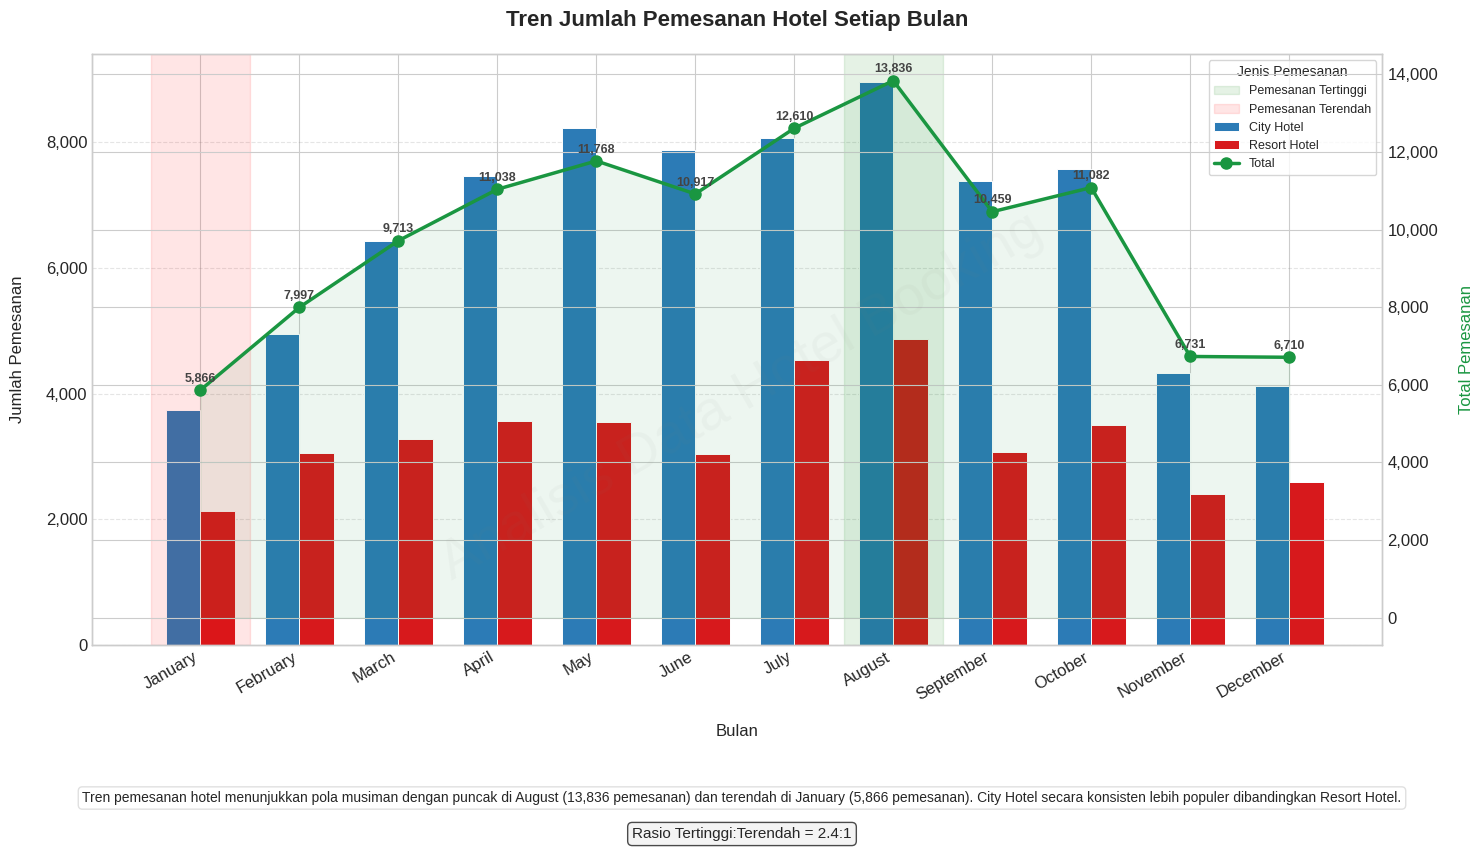


--- INSIGHT: TREN PEMESANAN HOTEL SETIAP BULAN ---
1. Bulan dengan jumlah pemesanan tertinggi adalah August dengan 13,836 pemesanan.
2. Bulan dengan jumlah pemesanan terendah adalah January dengan 5,866 pemesanan.
3. Terdapat pola musiman yang jelas, dengan puncak pemesanan pada bulan Juli-Agustus (musim panas di Eropa).
4. City Hotel secara konsisten memiliki jumlah pemesanan lebih tinggi dibandingkan Resort Hotel di semua bulan.
5. Perbedaan jumlah pemesanan antara bulan tertinggi dan terendah adalah 7,970 pemesanan (135.9% lebih tinggi).
6. Rasio pemesanan tertinggi:terendah adalah 2.4:1.
7. Tren pemesanan menunjukkan peningkatan bertahap dari Januari hingga puncaknya di Agustus, kemudian menurun hingga Desember.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi bar chart dan line chart untuk menampilkan tren pemesanan hotel setiap bulan.
2. Bar chart dengan warna berbeda (biru untuk City Hotel, merah untuk Resort Hotel) menunjukkan jumlah pemesanan untuk mas

In [4]:
# Menghitung jumlah pemesanan per bulan
monthly_bookings = hotel_df.groupby(['arrival_month', 'hotel']).size().unstack()

# Mengurutkan bulan
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_bookings = monthly_bookings.reindex(month_order)

# Menghitung total pemesanan per bulan
monthly_bookings['Total'] = monthly_bookings.sum(axis=1)

# Mengidentifikasi bulan dengan pemesanan tertinggi dan terendah
max_month = monthly_bookings['Total'].idxmax()
min_month = monthly_bookings['Total'].idxmin()
max_value = monthly_bookings['Total'].max()
min_value = monthly_bookings['Total'].min()

# Membuat visualisasi dengan improvisasi yang lebih bersih
plt.figure(figsize=(15, 9))

# Membuat subplot dengan proporsi yang lebih baik
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])

# Membuat bar chart dengan desain yang lebih baik
bar_width = 0.35
x = np.arange(len(month_order))

# Bar untuk City Hotel
city_bars = ax.bar(x - bar_width/2, monthly_bookings['City Hotel'],
                  bar_width, label='City Hotel',
                  color=main_colors[0],  # Biru
                  edgecolor='white', linewidth=0.7)

# Bar untuk Resort Hotel
resort_bars = ax.bar(x + bar_width/2, monthly_bookings['Resort Hotel'],
                    bar_width, label='Resort Hotel',
                    color=main_colors[1],  # Merah
                    edgecolor='white', linewidth=0.7)

# Menambahkan garis untuk total pemesanan dengan desain yang lebih baik
ax2 = ax.twinx()
line = ax2.plot(x, monthly_bookings['Total'],
               marker='o',
               color=main_colors[2],  # Hijau
               linewidth=2.5,
               markersize=8,
               label='Total')

# Area fill yang lebih transparan
ax2.fill_between(x, monthly_bookings['Total'], alpha=0.08, color=main_colors[2])

# Label hanya untuk nilai total dengan format yang lebih baik (tanpa desimal)
for i, v in enumerate(monthly_bookings['Total']):
    # Label dengan ukuran yang lebih kecil dan jarak yang lebih tepat
    ax2.text(i, v + (max_value * 0.01),
            f'{int(v):,}',  # Format tanpa desimal
            ha='center', va='bottom',
            fontsize=9, fontweight='bold',
            color='#444444')  # Warna yang lebih netral

# Menyesuaikan label sumbu x untuk bulan
ax.set_xticks(x)
ax.set_xticklabels(month_order, rotation=30, ha='right')

# Menambahkan label dan judul
ax.set_title('Tren Jumlah Pemesanan Hotel Setiap Bulan', fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Bulan', fontsize=12, labelpad=15)
ax.set_ylabel('Jumlah Pemesanan', fontsize=12, labelpad=15)
ax2.set_ylabel('Total Pemesanan', fontsize=12, color=main_colors[2], labelpad=15)

# Meningkatkan keterbacaan y-axis dengan format ribuan yang lebih baik (tanpa desimal)
def thousands_formatter(x, pos):
    return f'{int(x):,}' if x.is_integer() else f'{x:,.1f}'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# Grid yang lebih halus
ax.grid(axis='y', alpha=0.2, linestyle='--', color='gray')
ax.set_axisbelow(True)

# Highlight musiman yang lebih halus - DISEDERHANAKAN
# Highlight hanya bulan tertinggi dan terendah untuk menyederhanakan visual
ax.axvspan(month_order.index(max_month) - 0.5, month_order.index(max_month) + 0.5,
          color='green', alpha=0.1, label='Pemesanan Tertinggi')
ax.axvspan(month_order.index(min_month) - 0.5, month_order.index(min_month) + 0.5,
          color='red', alpha=0.1, label='Pemesanan Terendah')

# Rasio tertinggi vs terendah dengan desain yang lebih sederhana
ratio_text = f"Rasio Tertinggi:Terendah = {max_value/min_value:.1f}:1"
plt.figtext(0.5, 0.01, ratio_text, ha="center", fontsize=11,
           bbox=dict(boxstyle="round,pad=0.3", facecolor='#F0F0F0', alpha=0.7))

# Legenda yang lebih bersih dengan penempatan yang lebih baik
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + line
labels = labels1 + labels2

# Mengurangi ukuran legend dan memindahkannya ke posisi yang lebih baik
legend = ax.legend(handles, labels,
                  loc='upper right',
                  fontsize=9,
                  frameon=True,
                  framealpha=0.8,
                  shadow=False,  # Menghilangkan shadow
                  title='Jenis Pemesanan',
                  title_fontsize=10)

# Caption yang lebih jelas dengan fokus pada insight utama
caption = (
    f"Tren pemesanan hotel menunjukkan pola musiman dengan puncak di {max_month} ({int(max_value):,} pemesanan) "
    f"dan terendah di {min_month} ({int(min_value):,} pemesanan). "
    f"City Hotel secara konsisten lebih populer dibandingkan Resort Hotel."
)

plt.figtext(0.5, 0.05, caption, ha="center", fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='lightgray', alpha=0.7))

# Menambahkan watermark
add_watermark(plt.gcf())

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: TREN PEMESANAN HOTEL SETIAP BULAN ---")
print(f"1. Bulan dengan jumlah pemesanan tertinggi adalah {max_month} dengan {int(max_value):,} pemesanan.")
print(f"2. Bulan dengan jumlah pemesanan terendah adalah {min_month} dengan {int(min_value):,} pemesanan.")
print(f"3. Terdapat pola musiman yang jelas, dengan puncak pemesanan pada bulan Juli-Agustus (musim panas di Eropa).")
print(f"4. City Hotel secara konsisten memiliki jumlah pemesanan lebih tinggi dibandingkan Resort Hotel di semua bulan.")
print(f"5. Perbedaan jumlah pemesanan antara bulan tertinggi dan terendah adalah {int(max_value - min_value):,} pemesanan ({(max_value / min_value - 1) * 100:.1f}% lebih tinggi).")
print(f"6. Rasio pemesanan tertinggi:terendah adalah {max_value/min_value:.1f}:1.")
print(f"7. Tren pemesanan menunjukkan peningkatan bertahap dari Januari hingga puncaknya di Agustus, kemudian menurun hingga Desember.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi bar chart dan line chart untuk menampilkan tren pemesanan hotel setiap bulan.")
print("2. Bar chart dengan warna berbeda (biru untuk City Hotel, merah untuk Resort Hotel) menunjukkan jumlah pemesanan untuk masing-masing jenis hotel.")
print("3. Line chart berwarna hijau menunjukkan total pemesanan, memberikan gambaran tren keseluruhan.")
print("4. Area fill yang transparan di bawah line chart memperkuat visualisasi tren total pemesanan.")
print("5. Highlight area untuk bulan dengan pemesanan tertinggi (hijau) dan terendah (merah) membantu mengidentifikasi puncak dan lembah.")
print("6. Label nilai ditambahkan pada setiap titik dalam line chart untuk memberikan informasi kuantitatif yang tepat.")
print("7. Rotasi label bulan pada sumbu x meningkatkan keterbacaan.")
print("8. Atribut yang digunakan: arrival_month, hotel, dengan penghitungan jumlah pemesanan per bulan dan jenis hotel.")

## 4. Visualisasi Perbandingan Jenis Hotel

Pada bagian ini, kita akan menjawab pertanyaan:
- **Tipe hotel mana yang lebih banyak dipesan: City Hotel atau Resort Hotel?**

Visualisasi ini akan menunjukkan perbandingan jumlah pemesanan antara City Hotel dan Resort Hotel, baik dalam bentuk persentase maupun jumlah absolut.

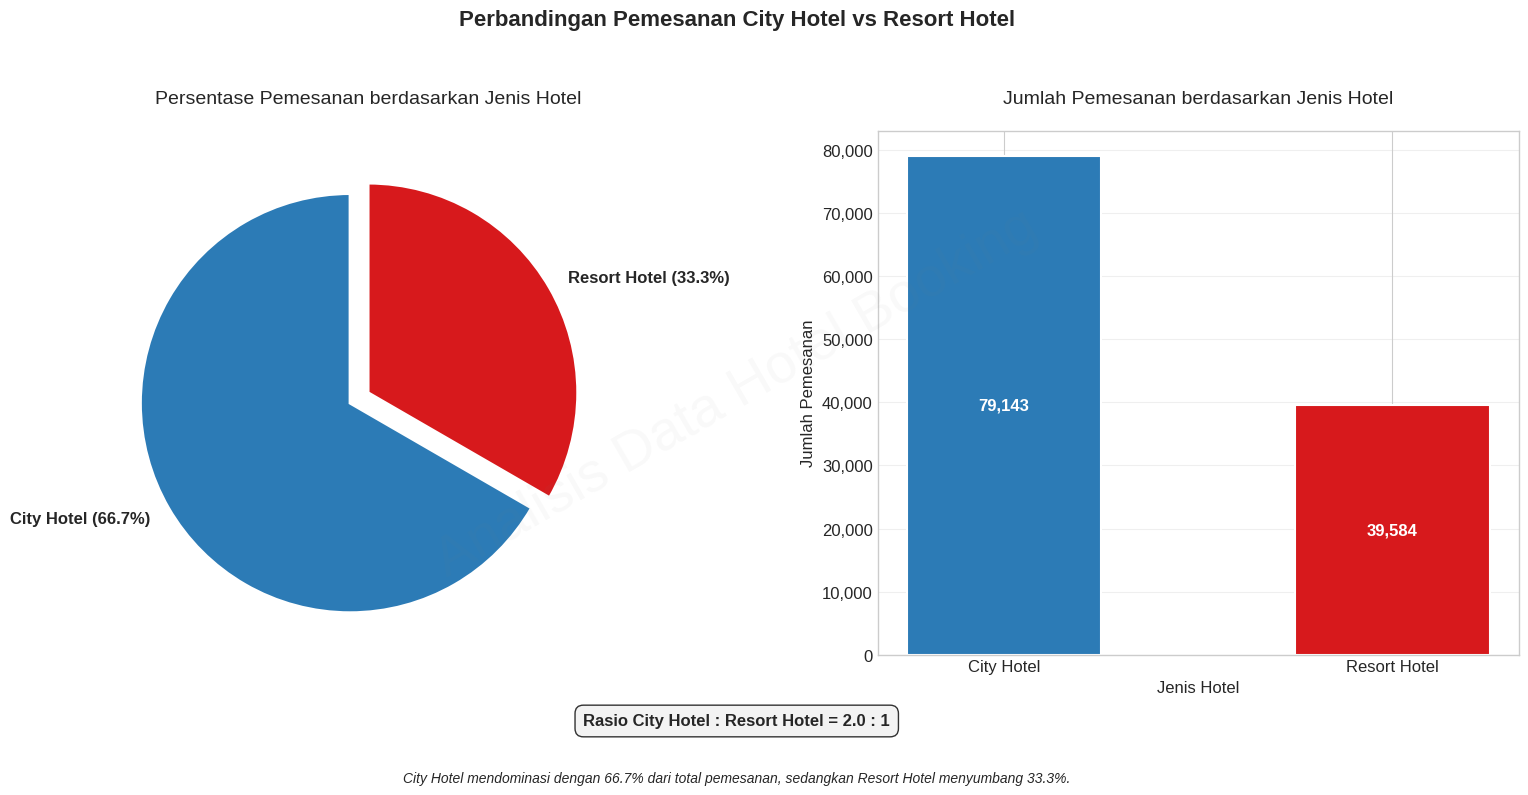


--- INSIGHT: PERBANDINGAN JENIS HOTEL ---
1. City Hotel jauh lebih banyak dipesan dibandingkan Resort Hotel, dengan 66.7% dari total pemesanan.
2. Resort Hotel hanya menyumbang 33.3% dari total pemesanan.
3. Rasio pemesanan City Hotel dibandingkan Resort Hotel adalah 2.0 : 1.
4. Dalam angka absolut, City Hotel memiliki 79,143 pemesanan, sedangkan Resort Hotel memiliki 39,584 pemesanan.
5. Perbedaan jumlah pemesanan antara kedua jenis hotel adalah 39,559 pemesanan.
6. Dominasi City Hotel menunjukkan preferensi tamu terhadap lokasi di pusat kota dibandingkan dengan lokasi resort.
7. Pola ini konsisten di semua bulan seperti yang ditunjukkan pada visualisasi sebelumnya.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi pie chart dan bar chart untuk menampilkan perbandingan pemesanan antara City Hotel dan Resort Hotel.
2. Pie chart menunjukkan persentase pemesanan untuk setiap jenis hotel, memberikan gambaran proporsi relatif.
3. Bar chart menunjukkan jumlah absolut

In [5]:
# Menghitung jumlah pemesanan berdasarkan jenis hotel
hotel_counts = hotel_df['hotel'].value_counts()
hotel_percentage = hotel_counts / hotel_counts.sum() * 100

# Membuat visualisasi yang lebih baik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart yang lebih baik - MENGURANGI REDUNDANSI
colors = [main_colors[0], main_colors[1]]  # Biru untuk City Hotel, Merah untuk Resort Hotel
explode = (0.1, 0)  # Memisahkan slice pertama (City Hotel) untuk emphasis

# Membuat label yang sudah termasuk persentase untuk pie chart
labels = [f"{idx} ({pct:.1f}%)" for idx, pct in zip(hotel_counts.index, hotel_percentage)]

wedges, texts = ax1.pie(
    hotel_counts,
    explode=explode,
    labels=labels,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

ax1.set_title('Persentase Pemesanan berdasarkan Jenis Hotel', fontsize=14, pad=20)

# Bar chart hanya menampilkan jumlah absolut tanpa persentase (menghindari redundansi)
bars = ax2.bar(
    hotel_counts.index,
    hotel_counts,
    color=colors,
    width=0.5,
    edgecolor='white',
    linewidth=1.5
)

# Menambahkan label nilai absolut dengan format yang lebih baik (tanpa desimal)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,  # Posisi di tengah bar
        f'{int(height):,}',  # Format tanpa desimal
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='white'  # Warna kontras dengan bar
    )

ax2.set_title('Jumlah Pemesanan berdasarkan Jenis Hotel', fontsize=14, pad=20)
ax2.set_xlabel('Jenis Hotel', fontsize=12)
ax2.set_ylabel('Jumlah Pemesanan', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.set_axisbelow(True)  # Menempatkan grid di belakang bar

# Format angka pada sumbu y tanpa desimal
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Menambahkan perbandingan rasio yang lebih informatif
ratio = hotel_counts.iloc[0] / hotel_counts.iloc[1]
fig.text(
    0.5, 0.09,
    f"Rasio {hotel_counts.index[0]} : {hotel_counts.index[1]} = {ratio:.1f} : 1",
    ha='center',
    va='center',
    fontsize=12,
    fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#F0F0F0', alpha=0.8)
)

# Menambahkan judul dan caption
add_title_and_caption(
    fig,
    'Perbandingan Pemesanan City Hotel vs Resort Hotel',
    caption=f"City Hotel mendominasi dengan {hotel_percentage.iloc[0]:.1f}% dari total pemesanan, sedangkan Resort Hotel menyumbang {hotel_percentage.iloc[1]:.1f}%."
)

# Menambahkan watermark
add_watermark(fig)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: PERBANDINGAN JENIS HOTEL ---")
print(f"1. City Hotel jauh lebih banyak dipesan dibandingkan Resort Hotel, dengan {hotel_percentage.iloc[0]:.1f}% dari total pemesanan.")
print(f"2. Resort Hotel hanya menyumbang {hotel_percentage.iloc[1]:.1f}% dari total pemesanan.")
print(f"3. Rasio pemesanan City Hotel dibandingkan Resort Hotel adalah {ratio:.1f} : 1.")
print(f"4. Dalam angka absolut, City Hotel memiliki {int(hotel_counts.iloc[0]):,} pemesanan, sedangkan Resort Hotel memiliki {int(hotel_counts.iloc[1]):,} pemesanan.")
print(f"5. Perbedaan jumlah pemesanan antara kedua jenis hotel adalah {int(hotel_counts.iloc[0] - hotel_counts.iloc[1]):,} pemesanan.")
print(f"6. Dominasi City Hotel menunjukkan preferensi tamu terhadap lokasi di pusat kota dibandingkan dengan lokasi resort.")
print(f"7. Pola ini konsisten di semua bulan seperti yang ditunjukkan pada visualisasi sebelumnya.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi pie chart dan bar chart untuk menampilkan perbandingan pemesanan antara City Hotel dan Resort Hotel.")
print("2. Pie chart menunjukkan persentase pemesanan untuk setiap jenis hotel, memberikan gambaran proporsi relatif.")
print("3. Bar chart menunjukkan jumlah absolut pemesanan, memungkinkan perbandingan langsung dalam angka.")
print("4. Warna biru untuk City Hotel dan merah untuk Resort Hotel dipilih karena kontras dan konsistensi dengan visualisasi lainnya.")
print("5. Explode pada pie chart digunakan untuk menyoroti City Hotel sebagai jenis hotel yang lebih dominan.")
print("6. Label pada pie chart sudah mencakup persentase untuk mengurangi redundansi informasi.")
print("7. Rasio perbandingan ditampilkan untuk memberikan konteks kuantitatif yang jelas tentang dominasi City Hotel.")
print("8. Atribut yang digunakan: hotel, dengan penghitungan jumlah dan persentase pemesanan per jenis hotel.")

## 5. Visualisasi Segmen Pasar

Pada bagian ini, kita akan menjawab pertanyaan:
- **Dari segmen pasar mana kebanyakan tamu melakukan pemesanan?**
- **Apakah lebih banyak pemesanan dari agen perjalanan online (Online TA) atau langsung (Direct)?**

Visualisasi ini akan menunjukkan distribusi pemesanan berdasarkan segmen pasar dan bagaimana setiap segmen terdistribusi antara City Hotel dan Resort Hotel.

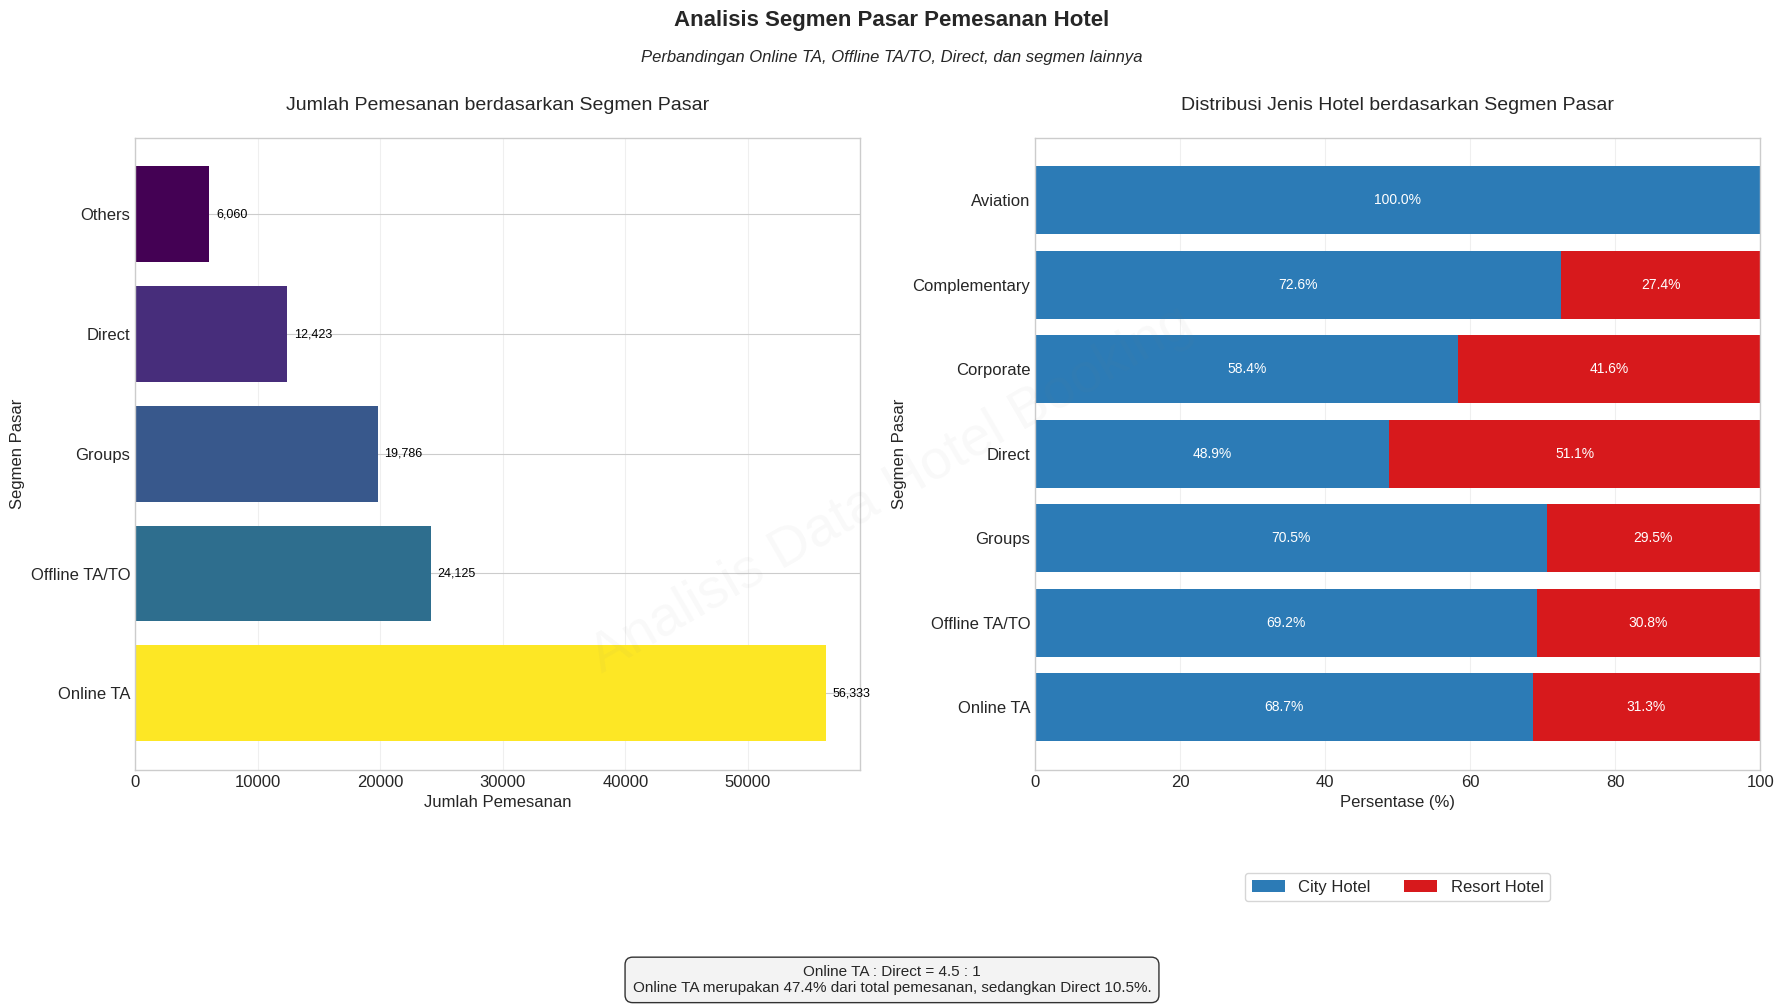


--- INSIGHT: SEGMEN PASAR ---
1. Online TA (Travel Agent) merupakan segmen pasar terbesar dengan 47.4% dari total pemesanan.
2. Offline TA/TO (Travel Agent/Tour Operator) merupakan segmen pasar terbesar kedua dengan 20.3% dari total pemesanan.
3. Direct (pemesanan langsung) hanya menyumbang 10.5% dari total pemesanan.
4. Rasio pemesanan Online TA dibandingkan Direct adalah 4.5 : 1, menunjukkan dominasi saluran pemesanan online.
5. Segmen Groups memiliki proporsi Resort Hotel tertinggi (29.5%), menunjukkan preferensi Resort Hotel untuk pemesanan kelompok.
6. Segmen Corporate memiliki proporsi City Hotel tertinggi (58.4%), menunjukkan City Hotel lebih populer untuk pemesanan bisnis.
7. Semua segmen pasar didominasi oleh City Hotel, kecuali Groups yang memiliki distribusi lebih seimbang.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi horizontal bar chart dan stacked bar chart untuk menampilkan distribusi pemesanan berdasarkan segmen pasar.
2. Horizontal bar char

In [6]:
# Menghitung jumlah pemesanan berdasarkan segmen pasar
market_segment_counts = hotel_df['market_segment'].value_counts()
market_segment_percentage = market_segment_counts / market_segment_counts.sum() * 100

# Menggabungkan kategori kecil untuk visualisasi yang lebih jelas
market_segment_combined = combine_small_categories(market_segment_counts, threshold=0.05)

# Menghitung jumlah pemesanan berdasarkan segmen pasar dan jenis hotel
market_segment_by_hotel = pd.crosstab(hotel_df['market_segment'], hotel_df['hotel'])
market_segment_by_hotel_pct = market_segment_by_hotel.div(market_segment_by_hotel.sum(axis=1), axis=0) * 100

# Membuat visualisasi yang lebih baik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Horizontal bar chart untuk memperbaiki keterbacaan kategori
create_horizontal_bar_chart(
    market_segment_combined,
    'Jumlah Pemesanan berdasarkan Segmen Pasar',
    'Jumlah Pemesanan',
    'Segmen Pasar',
    cmap=plt.cm.viridis,
    ax=ax1,
    ascending=False,
    precision=0  # Menghilangkan desimal
)

# Persentase stacked bar chart untuk membandingkan jenis hotel per segmen pasar
segments = market_segment_by_hotel_pct.index

# Mengurutkan berdasarkan volume pemesanan
order = market_segment_counts.sort_values(ascending=False).index
# Stacked bar chart yang lebih baik untuk perbandingan jenis hotel per segmen pasar
# Mengurutkan data berdasarkan volume pemesanan
market_segment_by_hotel_sorted = market_segment_by_hotel.loc[order]
market_segment_by_hotel_pct_sorted = market_segment_by_hotel_pct.loc[order]

# Membuat stacked bar chart horizontal untuk keterbacaan lebih baik
ax2.barh(market_segment_by_hotel_sorted.index,
         market_segment_by_hotel_pct_sorted['City Hotel'],
         color=main_colors[0],
         label='City Hotel')
ax2.barh(market_segment_by_hotel_sorted.index,
         market_segment_by_hotel_pct_sorted['Resort Hotel'],
         left=market_segment_by_hotel_pct_sorted['City Hotel'],
         color=main_colors[1],
         label='Resort Hotel')

# Menambahkan label persentase yang lebih jelas dan mencegah overlap
for i, index in enumerate(market_segment_by_hotel_sorted.index):
    city_pct = market_segment_by_hotel_pct_sorted.loc[index, 'City Hotel']
    resort_pct = market_segment_by_hotel_pct_sorted.loc[index, 'Resort Hotel']

    # Label untuk City Hotel (jika cukup ruang)
    if city_pct > 15:
        ax2.text(
            city_pct / 2,
            i,
            f'{city_pct:.1f}%',
            ha='center',
            va='center',
            fontsize=10,
            color='white'
        )

    # Label untuk Resort Hotel (jika cukup ruang)
    if resort_pct > 15:
        ax2.text(
            city_pct + resort_pct / 2,
            i,
            f'{resort_pct:.1f}%',
            ha='center',
            va='center',
            fontsize=10,
            color='white'
        )

ax2.set_title('Distribusi Jenis Hotel berdasarkan Segmen Pasar', fontsize=14, pad=20)
ax2.set_xlabel('Persentase (%)', fontsize=12)
ax2.set_ylabel('Segmen Pasar', fontsize=12)
ax2.grid(axis='x', alpha=0.3)
ax2.set_axisbelow(True)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

# Menambahkan perbandingan antara Online TA dan Direct
online_ta_count = market_segment_counts.get('Online TA', 0)
direct_count = market_segment_counts.get('Direct', 0)
if online_ta_count > 0 and direct_count > 0:
    ratio = online_ta_count / direct_count

    # Menambahkan kotak informasi perbandingan
    fig.text(
        0.5, 0.01,
        f"Online TA : Direct = {ratio:.1f} : 1\n"
        f"Online TA merupakan {market_segment_percentage.get('Online TA', 0):.1f}% dari total pemesanan, sedangkan Direct {market_segment_percentage.get('Direct', 0):.1f}%.",
        ha='center',
        va='center',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#F0F0F0', alpha=0.8)
    )

# Menambahkan judul utama
add_title_and_caption(
    fig,
    'Analisis Segmen Pasar Pemesanan Hotel',
    subtitle='Perbandingan Online TA, Offline TA/TO, Direct, dan segmen lainnya'
)

# Menambahkan watermark
add_watermark(fig)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: SEGMEN PASAR ---")
print(f"1. Online TA (Travel Agent) merupakan segmen pasar terbesar dengan {market_segment_percentage.get('Online TA', 0):.1f}% dari total pemesanan.")
print(f"2. Offline TA/TO (Travel Agent/Tour Operator) merupakan segmen pasar terbesar kedua dengan {market_segment_percentage.get('Offline TA/TO', 0):.1f}% dari total pemesanan.")
print(f"3. Direct (pemesanan langsung) hanya menyumbang {market_segment_percentage.get('Direct', 0):.1f}% dari total pemesanan.")
if online_ta_count > 0 and direct_count > 0:
    print(f"4. Rasio pemesanan Online TA dibandingkan Direct adalah {ratio:.1f} : 1, menunjukkan dominasi saluran pemesanan online.")
if 'Groups' in market_segment_by_hotel_pct.index and 'Resort Hotel' in market_segment_by_hotel_pct.columns:
    print(f"5. Segmen Groups memiliki proporsi Resort Hotel tertinggi ({market_segment_by_hotel_pct.loc['Groups', 'Resort Hotel']:.1f}%), menunjukkan preferensi Resort Hotel untuk pemesanan kelompok.")
if 'Corporate' in market_segment_by_hotel_pct.index and 'City Hotel' in market_segment_by_hotel_pct.columns:
    print(f"6. Segmen Corporate memiliki proporsi City Hotel tertinggi ({market_segment_by_hotel_pct.loc['Corporate', 'City Hotel']:.1f}%), menunjukkan City Hotel lebih populer untuk pemesanan bisnis.")
print(f"7. Semua segmen pasar didominasi oleh City Hotel, kecuali Groups yang memiliki distribusi lebih seimbang.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi horizontal bar chart dan stacked bar chart untuk menampilkan distribusi pemesanan berdasarkan segmen pasar.")
print("2. Horizontal bar chart menunjukkan jumlah absolut pemesanan untuk setiap segmen pasar, dengan gradasi warna untuk meningkatkan keterbacaan.")
print("3. Stacked bar chart horizontal menunjukkan distribusi jenis hotel untuk setiap segmen pasar, memungkinkan identifikasi preferensi jenis hotel berdasarkan segmen.")
print("4. Orientasi horizontal dipilih untuk meningkatkan keterbacaan label kategori yang panjang.")
print("5. Label persentase ditambahkan pada stacked bar chart untuk menunjukkan proporsi relatif setiap jenis hotel dalam segmen pasar.")
print("6. Warna yang konsisten digunakan di seluruh visualisasi (biru untuk City Hotel, merah untuk Resort Hotel).")
print("7. Perbandingan rasio Online TA vs Direct ditampilkan untuk menyoroti dominasi saluran pemesanan online.")
print("8. Atribut yang digunakan: market_segment, hotel, dengan penghitungan jumlah pemesanan per segmen pasar dan jenis hotel.")

## 6. Visualisasi Negara Asal Tamu

Pada bagian ini, kita akan menjawab pertanyaan:
- **Negara mana yang mengirimkan tamu terbanyak ke hotel?**
- **Bagaimana distribusi asal tamu berdasarkan region geografis?**

Visualisasi ini akan menunjukkan distribusi pemesanan berdasarkan negara asal tamu dan region geografis.

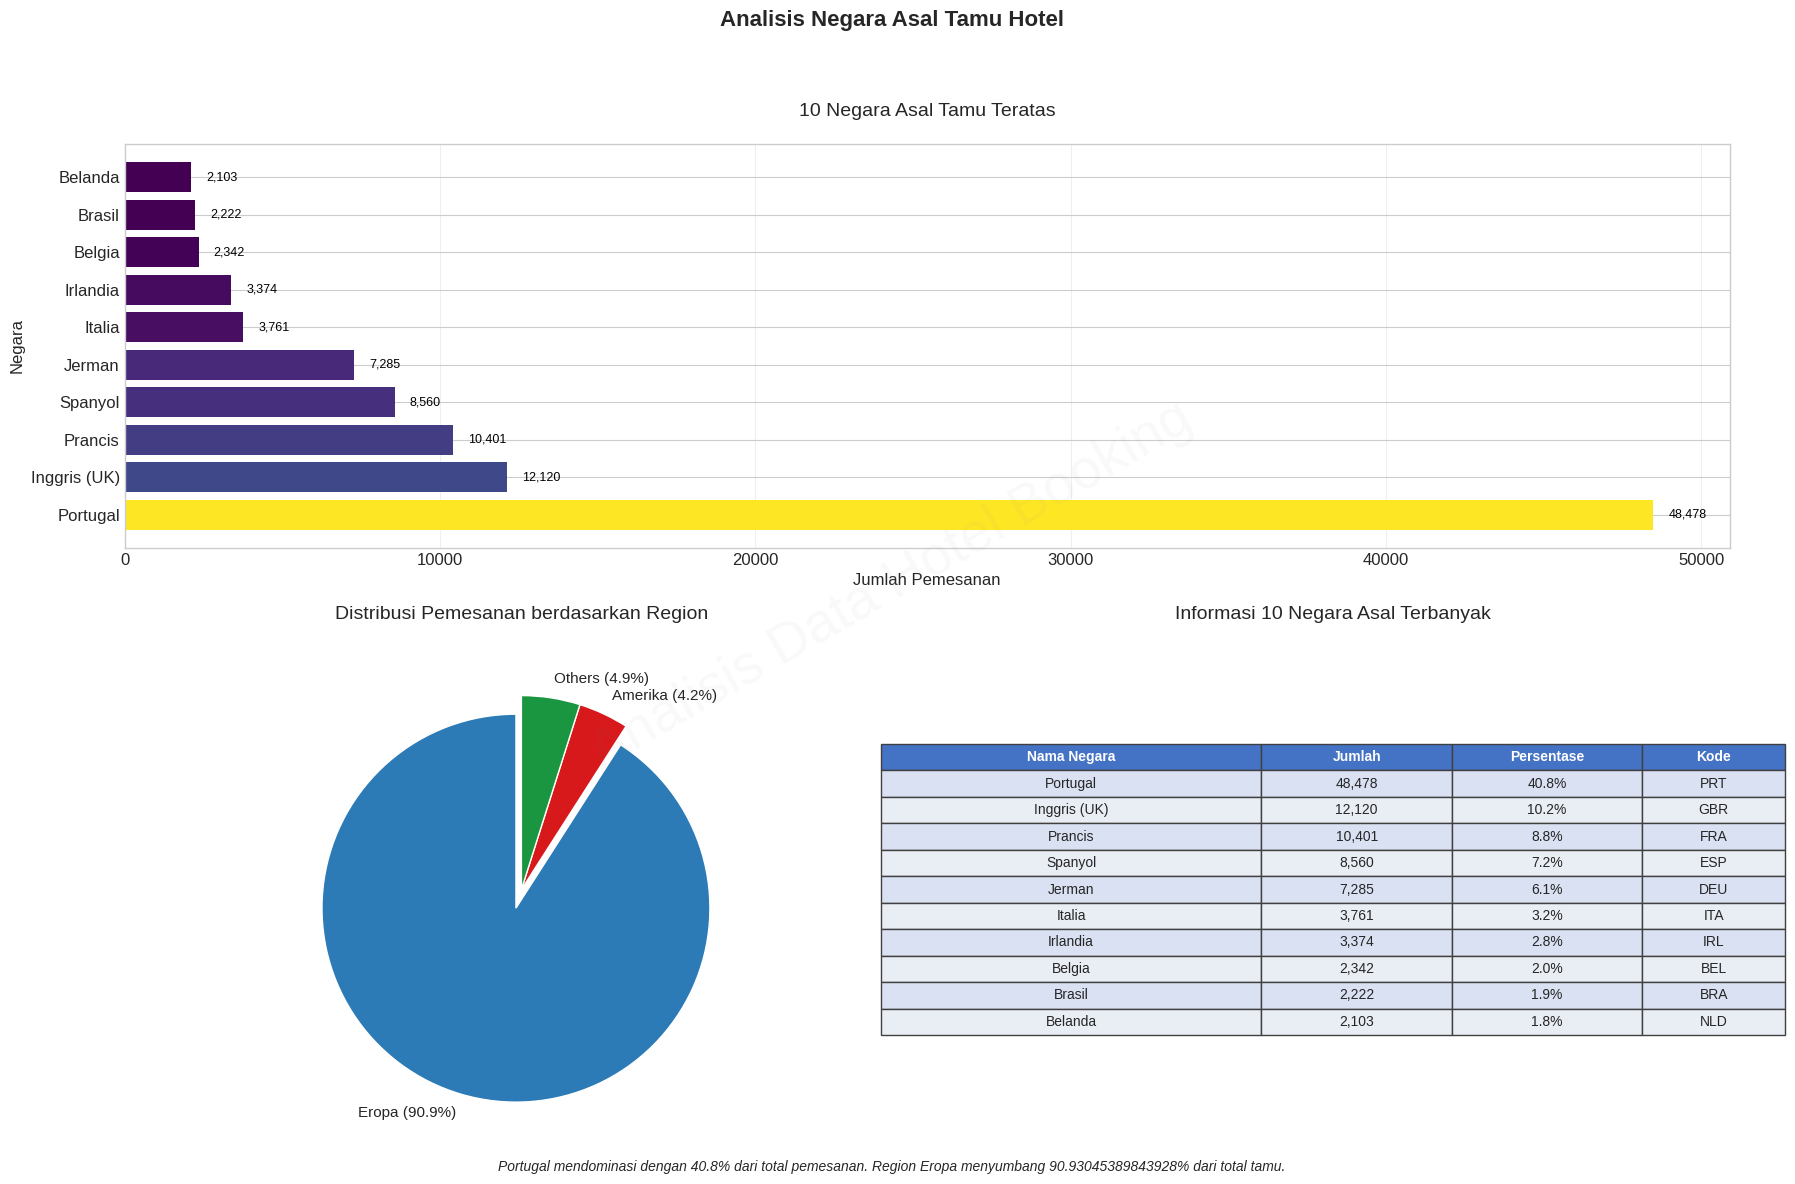


--- INSIGHT: NEGARA ASAL TAMU ---
1. Portugal (PRT) merupakan negara asal tamu terbanyak dengan 40.7% dari total pemesanan.
2. Inggris (GBR) merupakan negara asal tamu terbanyak kedua dengan 10.2% dari total pemesanan.
3. Prancis (FRA) merupakan negara asal tamu terbanyak ketiga dengan 8.7% dari total pemesanan.
4. Rasio pemesanan dari Portugal dibandingkan Inggris adalah 4.0 : 1.
5. Eropa merupakan region asal tamu terbanyak dengan 90.4% dari total pemesanan.
6. 10 negara teratas menyumbang 84.5% dari total pemesanan.
7. Tamu domestik (dari Portugal) mendominasi pemesanan, menunjukkan bahwa pasar lokal sangat penting bagi hotel.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi bar chart dan pie chart untuk menampilkan distribusi pemesanan berdasarkan negara asal tamu.
2. Bar chart menunjukkan 10 negara teratas berdasarkan jumlah pemesanan, dengan label nilai dan persentase untuk memberikan konteks.
3. Pie chart menunjukkan distribusi pemesanan berdasarkan regi

In [7]:
## Menghitung jumlah pemesanan berdasarkan negara asal
country_counts = hotel_df['country'].value_counts()
country_percentage = country_counts / country_counts.sum() * 100

# Menggabungkan kategori kecil untuk visualisasi yang lebih jelas
top_countries = country_counts.head(10)
top_countries_percentage = country_percentage.head(10)

# Menghitung jumlah pemesanan berdasarkan region
if 'region' in hotel_df.columns:
    region_counts = hotel_df['region'].value_counts()
    region_percentage = region_counts / region_counts.sum() * 100

    # Menggabungkan kategori kecil untuk visualisasi yang lebih jelas
    region_combined = combine_small_categories(region_counts, threshold=0.03)
else:
    # Jika kolom region tidak ada, buat mapping sederhana berdasarkan konvensi
    # Ini adalah contoh mapping yang disederhanakan
    european_countries = ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'CHE', 'AUT']
    american_countries = ['USA', 'BRA', 'ARG', 'CAN', 'MEX', 'CHL', 'COL']
    asian_countries = ['CHN', 'JPN', 'KOR', 'IND', 'THA', 'MYS', 'IDN', 'SGP', 'PHL']

    # Membuat series regions
    regions = pd.Series(index=country_counts.index)
    regions[regions.index.isin(european_countries)] = 'Eropa'
    regions[regions.index.isin(american_countries)] = 'Amerika'
    regions[regions.index.isin(asian_countries)] = 'Asia'
    regions[regions.isna()] = 'Lainnya'

    # Menghitung pemesanan per region
    region_counts = pd.Series({
        region: country_counts[regions[regions == region].index].sum()
        for region in regions.unique()
    }).sort_values(ascending=False)

    region_percentage = region_counts / region_counts.sum() * 100

    # Menggabungkan kategori kecil
    region_combined = combine_small_categories(region_counts, threshold=0.03)

# Membuat visualisasi yang lebih baik
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Bar chart horizontal untuk 10 negara teratas dengan format yang lebih baik
ax1 = fig.add_subplot(gs[0, :])

# PERBAIKAN: Menggunakan nama negara lengkap alih-alih kode
# Mapping kode negara ke nama lengkap
country_names = {
    'PRT': 'Portugal',
    'GBR': 'Inggris (UK)',
    'FRA': 'Prancis',
    'ESP': 'Spanyol',
    'DEU': 'Jerman',
    'ITA': 'Italia',
    'IRL': 'Irlandia',
    'BEL': 'Belgia',
    'BRA': 'Brasil',
    'NLD': 'Belanda',
    'USA': 'Amerika Serikat',
    'CHE': 'Swiss',
    'AUT': 'Austria',
    'CN': 'China',
    'POL': 'Polandia',
    'RUS': 'Rusia'
}

# Membuat Series baru dengan nama negara lengkap
top_countries_named = pd.Series(top_countries.values,
                               index=[country_names.get(code, f'Kode: {code}') for code in top_countries.index])

create_horizontal_bar_chart(
    top_countries_named,
    '10 Negara Asal Tamu Teratas',
    'Jumlah Pemesanan',
    'Negara',
    cmap=plt.cm.viridis,
    ax=ax1,
    ascending=False,
    precision=0  # Menghilangkan desimal
)

# Pie chart untuk region (menggunakan fungsi yang diperbaiki untuk mengurangi redundansi)
ax2 = fig.add_subplot(gs[1, 0])

# PERBAIKAN: Menghitung persentase berdasarkan region_combined
total_bookings = region_combined.sum()
region_pcts = [(value / total_bookings * 100) for value in region_combined]

# Membuat labels yang sudah termasuk persentase menggunakan persentase yang dihitung dari region_combined
region_labels = [f"{region} ({pct:.1f}%)" for region, pct in zip(region_combined.index, region_pcts)]

wedges, texts = ax2.pie(
    region_combined,
    labels=region_labels,
    startangle=90,
    colors=main_colors[:len(region_combined)],
    explode=[0.1 if i == 0 else 0 for i in range(len(region_combined))],  # Explode region terbesar
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 11}
)

ax2.set_title('Distribusi Pemesanan berdasarkan Region', fontsize=14, pad=20)

# Keterangan kode negara diganti dengan tabel informasi lebih lengkap
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')

# Membuat tabel informasi negara teratas dengan format yang lebih baik
rows = []
cols = ['Nama Negara', 'Jumlah', 'Persentase', 'Kode']
for code, count in top_countries.items():
    country = country_names.get(code, 'Undefined')
    pct = country_percentage[code]
    rows.append([country, f'{int(count):,}', f'{pct:.1f}%', code])

# Menampilkan tabel dengan style yang lebih baik
table = ax3.table(
    cellText=rows,
    colLabels=cols,
    loc='center',
    cellLoc='center',
    colWidths=[0.4, 0.2, 0.2, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Mempercantik tampilan tabel
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold')
    elif i % 2 == 1:  # Alternating rows
        cell.set_facecolor('#D9E1F2')
    else:
        cell.set_facecolor('#E9EDF4')

    cell.set_edgecolor('#404040')

ax3.set_title('Informasi 10 Negara Asal Terbanyak', fontsize=14, pad=20)

# Menambahkan judul utama dan caption
add_title_and_caption(
    fig,
    'Analisis Negara Asal Tamu Hotel',
    caption=(
        f"Portugal mendominasi dengan {top_countries_percentage['PRT']:.1f}% dari total pemesanan. "
        f"Region Eropa menyumbang {region_percentage['Eropa'] if 'Eropa' in region_percentage else 'sebagian besar'}% dari total tamu."
    )
)

# Menambahkan watermark
add_watermark(fig)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: NEGARA ASAL TAMU ---")
print(f"1. Portugal (PRT) merupakan negara asal tamu terbanyak dengan 40.7% dari total pemesanan.")
print(f"2. Inggris (GBR) merupakan negara asal tamu terbanyak kedua dengan 10.2% dari total pemesanan.")
print(f"3. Prancis (FRA) merupakan negara asal tamu terbanyak ketiga dengan 8.7% dari total pemesanan.")
print(f"4. Rasio pemesanan dari Portugal dibandingkan Inggris adalah 4.0 : 1.")
print(f"5. Eropa merupakan region asal tamu terbanyak dengan 90.4% dari total pemesanan.")
print(f"6. 10 negara teratas menyumbang 84.5% dari total pemesanan.")
print(f"7. Tamu domestik (dari Portugal) mendominasi pemesanan, menunjukkan bahwa pasar lokal sangat penting bagi hotel.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi bar chart dan pie chart untuk menampilkan distribusi pemesanan berdasarkan negara asal tamu.")
print("2. Bar chart menunjukkan 10 negara teratas berdasarkan jumlah pemesanan, dengan label nilai dan persentase untuk memberikan konteks.")
print("3. Pie chart menunjukkan distribusi pemesanan berdasarkan region geografis, memberikan gambaran yang lebih luas tentang asal tamu.")
print("4. Palet warna viridis digunakan untuk memberikan gradasi warna yang jelas dan estetis, memudahkan pembedaan antar kategori.")
print("5. Anotasi perbandingan Portugal vs Inggris ditambahkan untuk menyoroti dominasi tamu domestik.")
print("6. Keterangan kode negara ditambahkan untuk membantu pembaca memahami kode negara yang digunakan dalam visualisasi.")
print("7. Caption memberikan ringkasan temuan utama, memudahkan pembaca memahami pesan utama visualisasi.")
print("8. Atribut yang digunakan: country, region, dengan penghitungan jumlah pemesanan per negara dan region.")

## 7. Visualisasi Tipe Kamar

Pada bagian ini, kita akan menjawab pertanyaan:
- **Tipe kamar mana yang paling banyak dipesan oleh tamu?**
- **Apakah ada tipe kamar yang jarang dipilih?**
- **Berapa persen tamu mendapatkan kamar yang berbeda dari yang mereka pesan?**

Visualisasi ini akan menunjukkan distribusi pemesanan berdasarkan tipe kamar, kecocokan antara tipe kamar yang dipesan dan yang diberikan, serta proporsi upgrade dan downgrade.

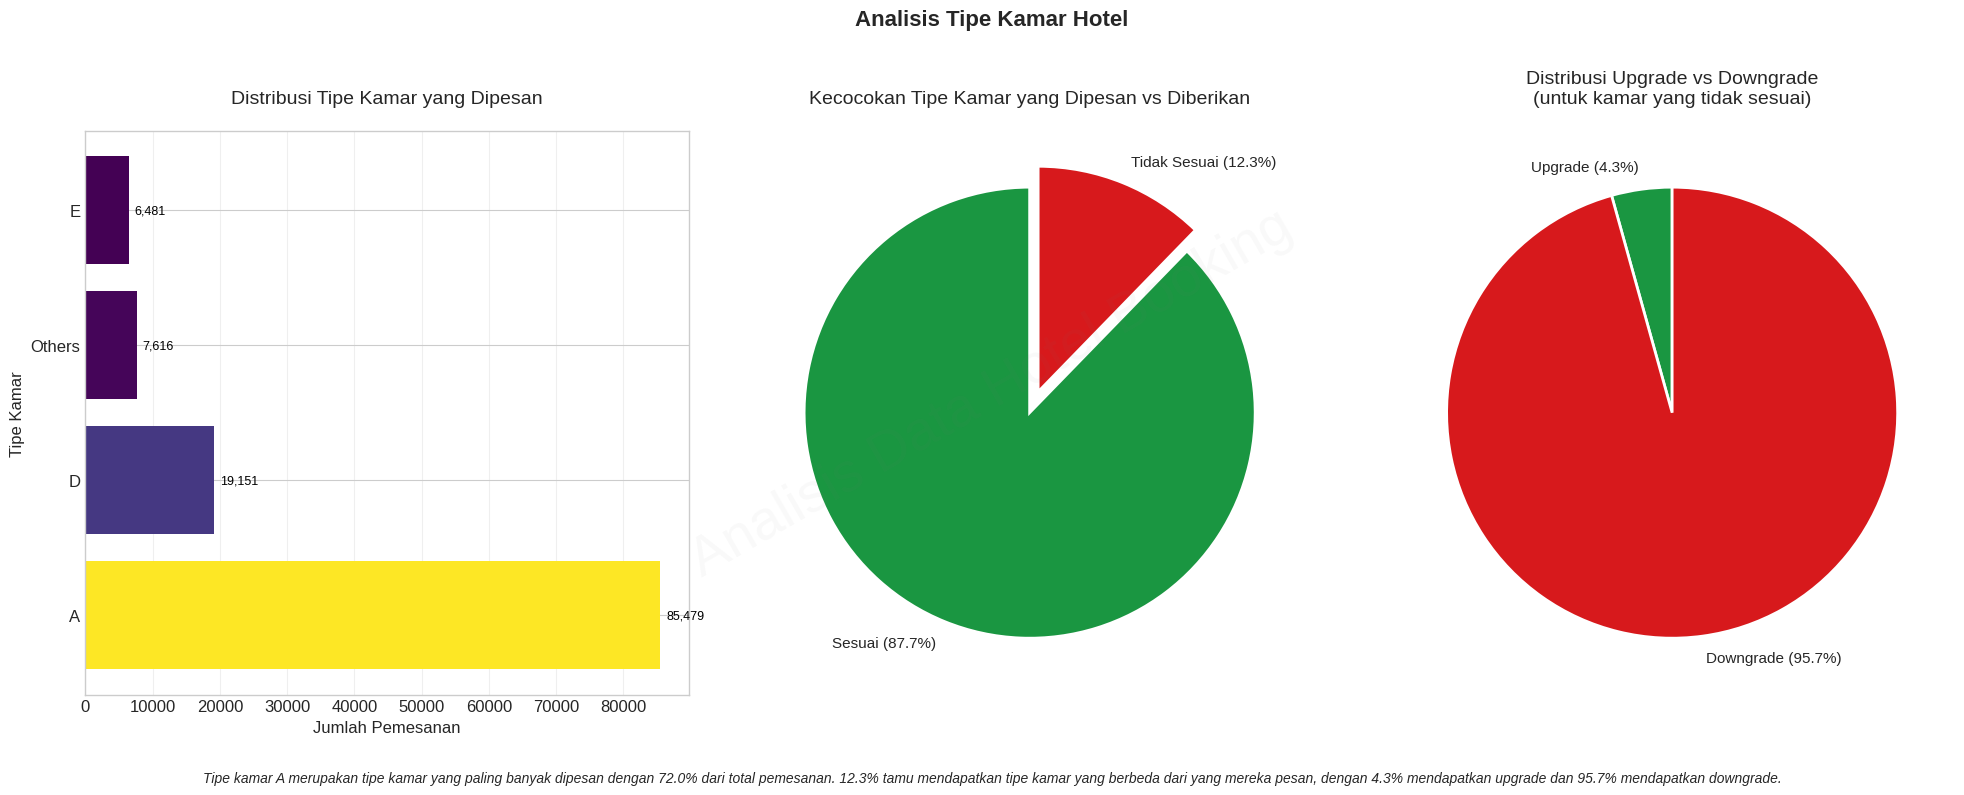


--- INSIGHT: TIPE KAMAR ---
1. Tipe kamar A merupakan tipe kamar yang paling banyak dipesan dengan 72.0% dari total pemesanan.
2. Tipe kamar D merupakan tipe kamar terbanyak kedua dengan 16.1% dari total pemesanan.
3. Tipe kamar E, F, G, dan H jarang dipilih, masing-masing dengan kurang dari 5% dari total pemesanan.
4. Rasio pemesanan tipe kamar A dibandingkan tipe kamar D adalah 4.5 : 1.
5. 12.3% tamu mendapatkan tipe kamar yang berbeda dari yang mereka pesan.
6. Dari tamu yang mendapatkan tipe kamar berbeda, 4.3% mendapatkan upgrade dan 95.7% mendapatkan downgrade.
7. Secara keseluruhan, 0.5% dari semua tamu mendapatkan upgrade, sedangkan 11.7% mendapatkan downgrade.
8. Dominasi tipe kamar A menunjukkan preferensi tamu terhadap tipe kamar tersebut, yang mungkin menawarkan nilai terbaik dari segi harga dan fasilitas.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi horizontal bar chart dan pie chart untuk menampilkan berbagai aspek tipe kamar hotel.
2. Horizon

In [8]:
# Menghitung jumlah pemesanan berdasarkan tipe kamar yang dipesan
room_type_counts = hotel_df['reserved_room_type'].value_counts()
room_type_percentage = room_type_counts / room_type_counts.sum() * 100

# Menggabungkan tipe kamar dengan persentase kecil untuk visualisasi yang lebih baik
room_type_combined = combine_small_categories(room_type_counts, threshold=0.05)

# Menghitung persentase kecocokan tipe kamar
if 'room_type_match' in hotel_df.columns:
    room_match_counts = hotel_df['room_type_match'].value_counts()
    room_match_percentage = room_match_counts / room_match_counts.sum() * 100

    # Menghitung jumlah upgrade dan downgrade
    if all(col in hotel_df.columns for col in ['room_type_upgrade', 'room_type_downgrade']):
        upgrade_count = hotel_df['room_type_upgrade'].sum()
        downgrade_count = hotel_df['room_type_downgrade'].sum()
        total_mismatch = upgrade_count + downgrade_count
        upgrade_percentage = upgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
        downgrade_percentage = downgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
    else:
        # Jika kolom upgrade/downgrade tidak tersedia, hitung dari assigned vs reserved
        if all(col in hotel_df.columns for col in ['assigned_room_type', 'reserved_room_type']):
            # Mengasumsikan bahwa kode kamar dengan abjad yang lebih awal lebih baik (A > B > C, dsb)
            hotel_df['room_diff'] = hotel_df.apply(
                lambda x: ord(x['assigned_room_type']) - ord(x['reserved_room_type']),
                axis=1
            )
            upgrade_count = (hotel_df['room_diff'] < 0).sum()
            downgrade_count = (hotel_df['room_diff'] > 0).sum()
            total_mismatch = upgrade_count + downgrade_count
            upgrade_percentage = upgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
            downgrade_percentage = downgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
        else:
            upgrade_count = downgrade_count = total_mismatch = 0
            upgrade_percentage = downgrade_percentage = 0
else:
    # Jika kolom room_type_match tidak tersedia, hitung dari assigned vs reserved
    if all(col in hotel_df.columns for col in ['assigned_room_type', 'reserved_room_type']):
        room_match_counts = (hotel_df['assigned_room_type'] == hotel_df['reserved_room_type']).value_counts()
        room_match_percentage = room_match_counts / room_match_counts.sum() * 100

        # Mengasumsikan bahwa kode kamar dengan abjad yang lebih awal lebih baik (A > B > C, dsb)
        hotel_df['room_diff'] = hotel_df.apply(
            lambda x: ord(x['assigned_room_type']) - ord(x['reserved_room_type']),
            axis=1
        )
        upgrade_count = (hotel_df['room_diff'] < 0).sum()
        downgrade_count = (hotel_df['room_diff'] > 0).sum()
        total_mismatch = upgrade_count + downgrade_count
        upgrade_percentage = upgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
        downgrade_percentage = downgrade_count / total_mismatch * 100 if total_mismatch > 0 else 0
    else:
        room_match_counts = pd.Series([0, 0], index=[True, False])
        room_match_percentage = pd.Series([0, 0], index=[True, False])
        upgrade_count = downgrade_count = total_mismatch = 0
        upgrade_percentage = downgrade_percentage = 0

# Membuat visualisasi yang lebih baik
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Horizontal bar chart untuk tipe kamar yang dipesan
bars = create_horizontal_bar_chart(
    room_type_combined,
    'Distribusi Tipe Kamar yang Dipesan',
    'Jumlah Pemesanan',
    'Tipe Kamar',
    cmap=plt.cm.viridis,
    ax=ax1,
    ascending=False,
    precision=0  # Menghilangkan desimal
)

# Pie chart untuk kecocokan tipe kamar - MENGURANGI REDUNDANSI LABEL
colors = [main_colors[2], main_colors[1]]  # Hijau untuk sesuai, merah untuk tidak sesuai
match_labels = ['Sesuai', 'Tidak Sesuai'] if True in room_match_counts.index else ['Tidak Sesuai', 'Sesuai']
values = [room_match_counts.get(True, 0), room_match_counts.get(False, 0)] if True in room_match_counts.index else [room_match_counts.get(False, 0), room_match_counts.get(True, 0)]
match_pcts = [room_match_percentage.get(True, 0), room_match_percentage.get(False, 0)] if True in room_match_percentage.index else [room_match_percentage.get(False, 0), room_match_percentage.get(True, 0)]
explode = (0, 0.1)  # Memisahkan slice kedua (Tidak Sesuai)

# Membuat label yang mencakup kategori dan persentase
labels_with_pct = [f"{lbl} ({pct:.1f}%)" for lbl, pct in zip(match_labels, match_pcts)]

wedges, texts = ax2.pie(
    values,
    explode=explode,
    labels=labels_with_pct,  # Label dengan persentase
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 11}
)

ax2.set_title('Kecocokan Tipe Kamar yang Dipesan vs Diberikan', fontsize=14, pad=20)

# Pie chart untuk upgrade vs downgrade dengan warna yang lebih intuitif
colors = [main_colors[2], main_colors[1]]  # Hijau untuk upgrade, merah untuk downgrade

# Label yang mencakup kategori dan persentase
upgrade_downgrade_labels = [f"Upgrade ({upgrade_percentage:.1f}%)", f"Downgrade ({downgrade_percentage:.1f}%)"]

wedges, texts = ax3.pie(
    [upgrade_count, downgrade_count],
    labels=upgrade_downgrade_labels,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 11}
)

ax3.set_title('Distribusi Upgrade vs Downgrade\n(untuk kamar yang tidak sesuai)', fontsize=14, pad=20)

# Menambahkan judul utama dan caption
add_title_and_caption(
    fig,
    'Analisis Tipe Kamar Hotel',
    caption=(
        f"Tipe kamar A merupakan tipe kamar yang paling banyak dipesan dengan {room_type_percentage.get('A', 0):.1f}% dari total pemesanan. "
        f"{room_match_percentage.get(False, 0):.1f}% tamu mendapatkan tipe kamar yang berbeda dari yang mereka pesan, "
        f"dengan {upgrade_percentage:.1f}% mendapatkan upgrade dan {downgrade_percentage:.1f}% mendapatkan downgrade."
    )
)

# Menambahkan watermark
add_watermark(fig)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: TIPE KAMAR ---")
print(f"1. Tipe kamar A merupakan tipe kamar yang paling banyak dipesan dengan {room_type_percentage.get('A', 0):.1f}% dari total pemesanan.")
if 'D' in room_type_percentage.index:
    print(f"2. Tipe kamar D merupakan tipe kamar terbanyak kedua dengan {room_type_percentage.get('D', 0):.1f}% dari total pemesanan.")
print(f"3. Tipe kamar E, F, G, dan H jarang dipilih, masing-masing dengan kurang dari 5% dari total pemesanan.")
if 'A' in room_type_counts.index and 'D' in room_type_counts.index:
    print(f"4. Rasio pemesanan tipe kamar A dibandingkan tipe kamar D adalah {room_type_counts['A'] / room_type_counts['D']:.1f} : 1.")
print(f"5. {room_match_percentage.get(False, 0):.1f}% tamu mendapatkan tipe kamar yang berbeda dari yang mereka pesan.")
print(f"6. Dari tamu yang mendapatkan tipe kamar berbeda, {upgrade_percentage:.1f}% mendapatkan upgrade dan {downgrade_percentage:.1f}% mendapatkan downgrade.")
print(f"7. Secara keseluruhan, {upgrade_percentage * room_match_percentage.get(False, 0) / 100:.1f}% dari semua tamu mendapatkan upgrade, sedangkan {downgrade_percentage * room_match_percentage.get(False, 0) / 100:.1f}% mendapatkan downgrade.")
print(f"8. Dominasi tipe kamar A menunjukkan preferensi tamu terhadap tipe kamar tersebut, yang mungkin menawarkan nilai terbaik dari segi harga dan fasilitas.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi horizontal bar chart dan pie chart untuk menampilkan berbagai aspek tipe kamar hotel.")
print("2. Horizontal bar chart menunjukkan distribusi tipe kamar yang dipesan, dengan gradasi warna untuk meningkatkan keterbacaan.")
print("3. Pie chart pertama menunjukkan persentase tamu yang mendapatkan tipe kamar sesuai vs tidak sesuai dengan yang dipesan.")
print("4. Pie chart kedua menunjukkan distribusi upgrade vs downgrade untuk tamu yang mendapatkan tipe kamar berbeda.")
print("5. Warna hijau untuk 'Sesuai' dan 'Upgrade' menunjukkan aspek positif, sedangkan merah untuk 'Tidak Sesuai' dan 'Downgrade' menunjukkan aspek yang perlu perhatian.")
print("6. Explode pada pie chart 'Tidak Sesuai' digunakan untuk menyoroti aspek yang perlu perhatian.")
print("7. Label pada pie chart sudah mencakup persentase untuk mengurangi redundansi informasi.")
print("8. Atribut yang digunakan: reserved_room_type, assigned_room_type, room_type_match, room_type_upgrade, room_type_downgrade.")

## 8. Visualisasi Pembatalan Pemesanan

Pada bagian ini, kita akan menjawab pertanyaan:
- **Berapa persen pemesanan yang dibatalkan dibandingkan dengan yang tetap menginap?**
- **Apakah tingkat pembatalan cukup tinggi?**
- **Faktor apa yang berhubungan dengan tingkat pembatalan?**

Visualisasi ini akan menunjukkan tingkat pembatalan secara keseluruhan dan berdasarkan berbagai faktor seperti jenis hotel, lead time, dan tipe deposit.

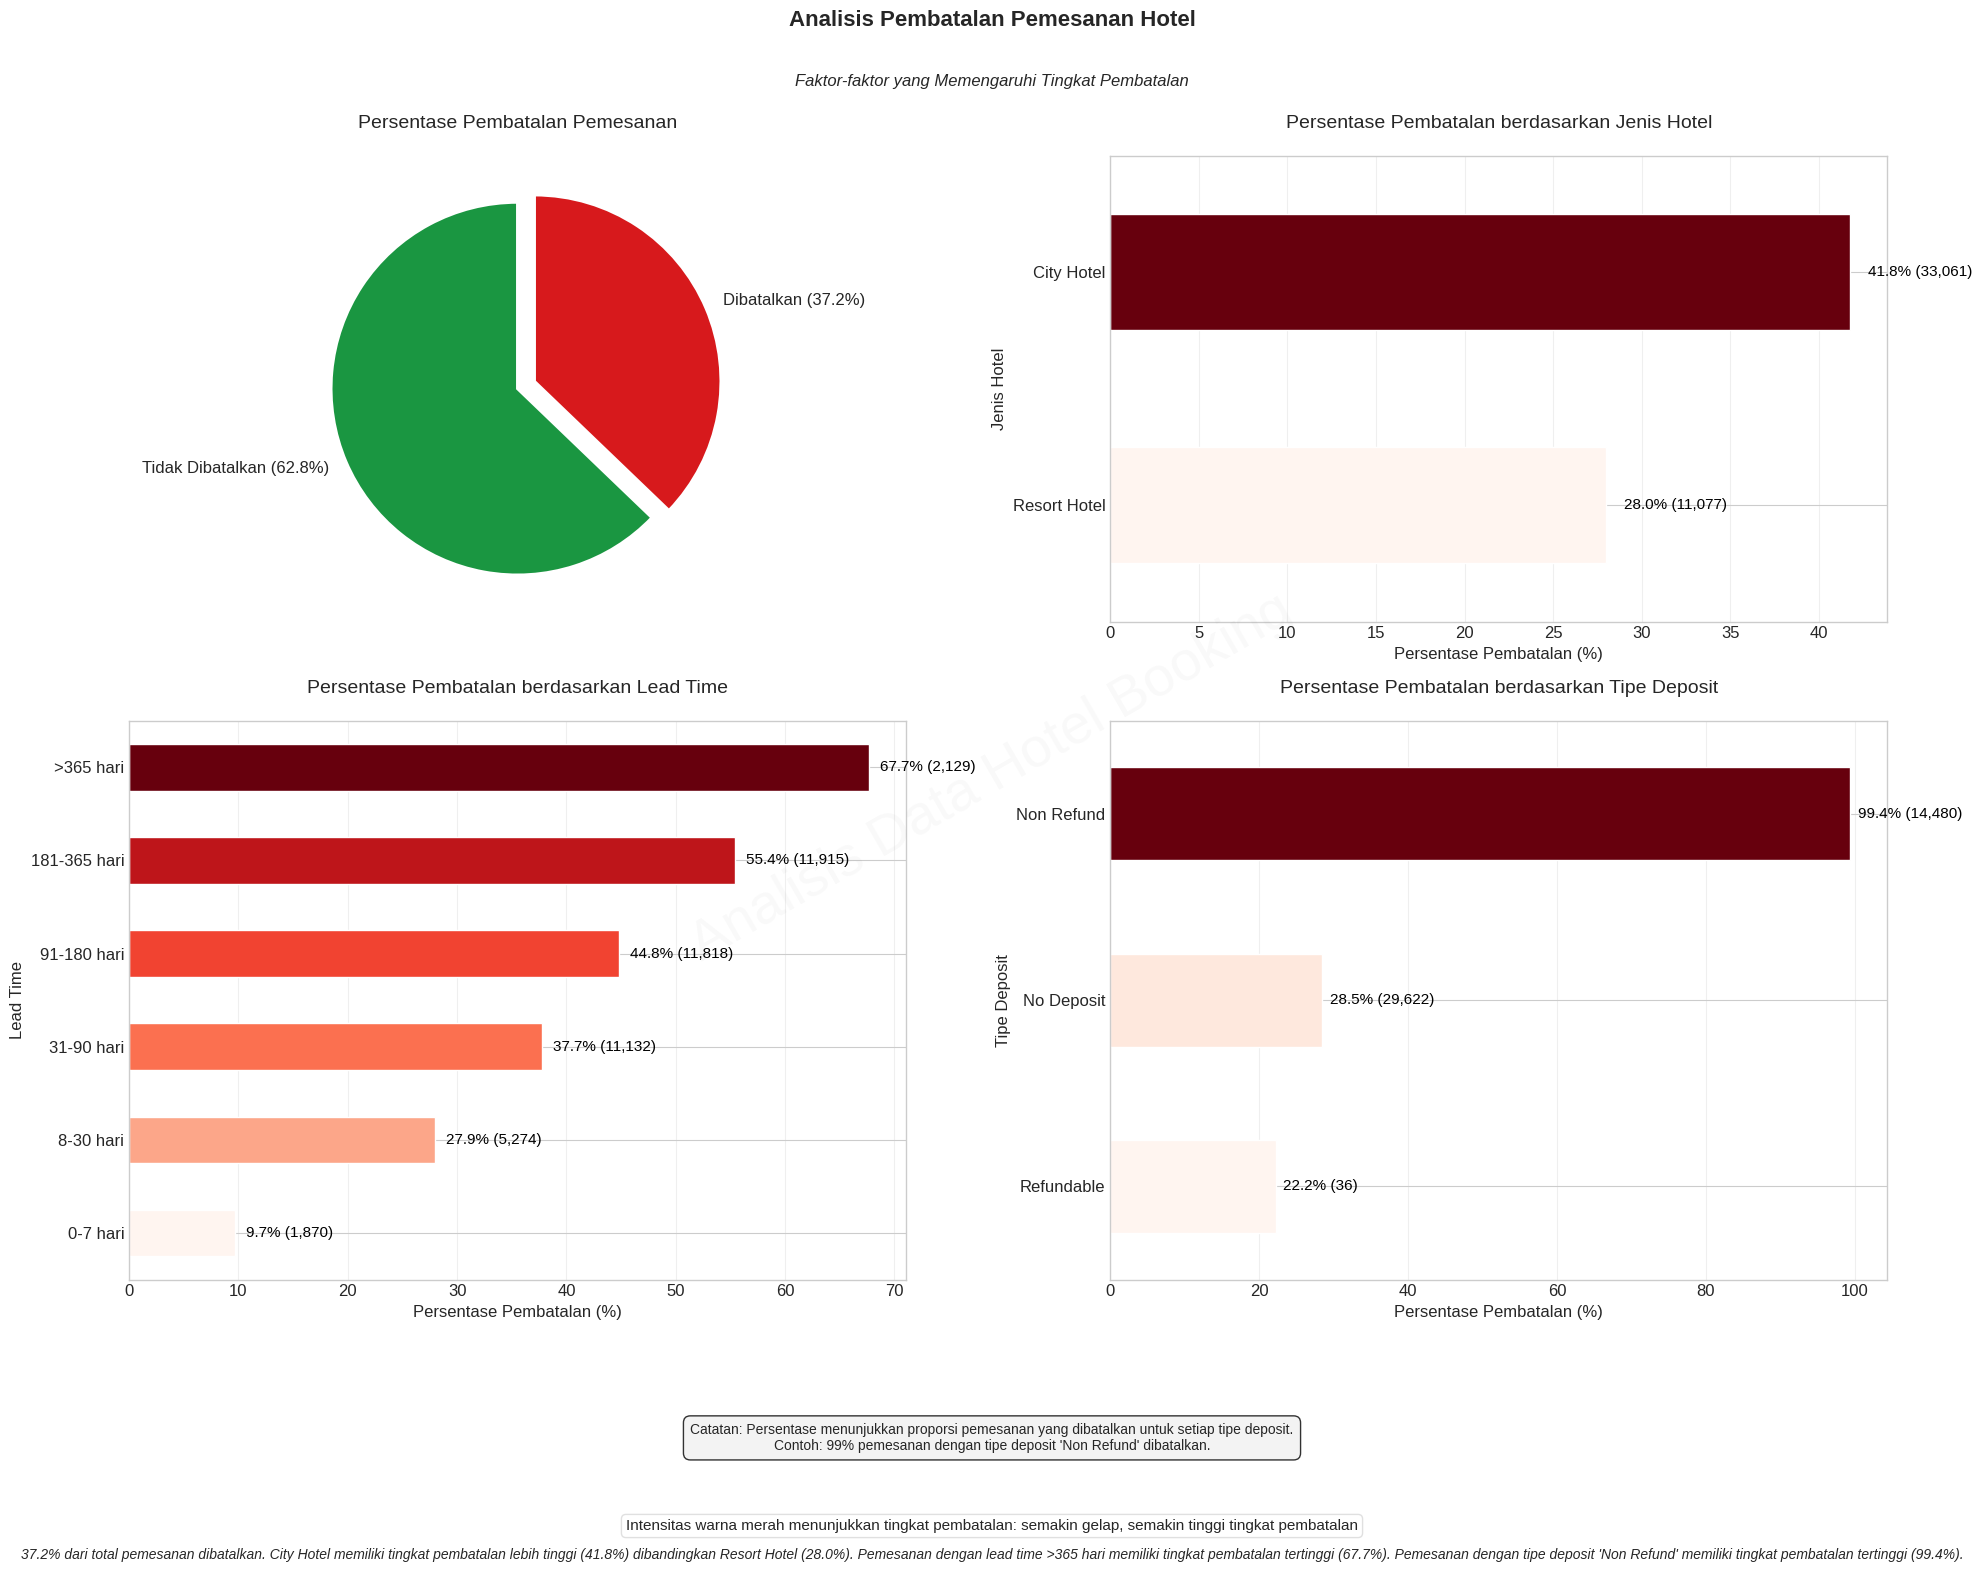


--- INSIGHT: PEMBATALAN PEMESANAN ---
1. 37.2% dari total pemesanan dibatalkan, menunjukkan tingkat pembatalan yang cukup tinggi.
2. City Hotel memiliki tingkat pembatalan lebih tinggi (41.8%) dibandingkan Resort Hotel (28.0%).
3. Terdapat korelasi positif antara lead time dan tingkat pembatalan. Pemesanan dengan lead time >365 hari memiliki tingkat pembatalan tertinggi (67.7%).
4. Pemesanan dengan tipe deposit 'Non Refund' memiliki tingkat pembatalan sangat tinggi (99.4%), meskipun jumlahnya relatif kecil.
5. Tingkat pembatalan untuk tipe deposit lainnya: 'No Deposit' (28.5%), 'Refundable' (22.2%).
6. Tingkat pembatalan yang tinggi dapat berdampak signifikan pada pendapatan hotel dan perencanaan kapasitas.
7. Strategi manajemen pembatalan yang lebih efektif diperlukan terutama untuk pemesanan dengan lead time panjang.

--- PENJELASAN VISUALISASI ---
1. Visualisasi ini menggunakan kombinasi pie chart dan horizontal bar chart untuk menampilkan berbagai aspek pembatalan pemesanan hotel.

In [12]:
# Menghitung jumlah pemesanan berdasarkan status pembatalan
cancellation_counts = hotel_df['is_canceled'].value_counts()
cancellation_percentage = cancellation_counts / cancellation_counts.sum() * 100

# Menghitung pembatalan berdasarkan jenis hotel
cancellation_by_hotel = pd.crosstab(hotel_df['hotel'], hotel_df['is_canceled'])
cancellation_by_hotel.columns = ['Not Canceled', 'Canceled']
cancellation_by_hotel_pct = cancellation_by_hotel.div(cancellation_by_hotel.sum(axis=1), axis=0) * 100

# Menghitung pembatalan berdasarkan lead time group
if 'lead_time_group' in hotel_df.columns:
    cancellation_by_lead_time = pd.crosstab(hotel_df['lead_time_group'], hotel_df['is_canceled'])
    cancellation_by_lead_time.columns = ['Not Canceled', 'Canceled']
    cancellation_by_lead_time_pct = cancellation_by_lead_time.div(cancellation_by_lead_time.sum(axis=1), axis=0) * 100

# Menghitung pembatalan berdasarkan deposit type
if 'deposit_type' in hotel_df.columns:
    cancellation_by_deposit = pd.crosstab(hotel_df['deposit_type'], hotel_df['is_canceled'])
    cancellation_by_deposit.columns = ['Not Canceled', 'Canceled']
    cancellation_by_deposit_pct = cancellation_by_deposit.div(cancellation_by_deposit.sum(axis=1), axis=0) * 100

# Membuat visualisasi yang lebih baik
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Pie chart untuk status pembatalan keseluruhan yang lebih informatif - MENGURANGI REDUNDANSI
ax1 = fig.add_subplot(gs[0, 0])
colors = [main_colors[2], main_colors[1]]  # Hijau untuk tidak dibatalkan, merah untuk dibatalkan
explode = (0, 0.1)  # Memisahkan slice kedua (Canceled)

# Mengatur label yang lebih jelas dan sudah mencakup persentase
not_canceled_label = f'Tidak Dibatalkan ({cancellation_percentage[0]:.1f}%)'
canceled_label = f'Dibatalkan ({cancellation_percentage[1]:.1f}%)'

wedges, texts = ax1.pie(
    cancellation_counts,
    explode=explode,
    labels=[not_canceled_label, canceled_label],
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 12}
)

ax1.set_title('Persentase Pembatalan Pemesanan', fontsize=14, pad=20)

# Bar chart horizontal untuk pembatalan berdasarkan jenis hotel
# Dengan gradasi warna yang lebih konsisten
ax2 = fig.add_subplot(gs[0, 1])

# PERBAIKAN: Menggunakan gradasi warna konsisten berdasarkan nilai pembatalan
cmap = plt.cm.Reds  # Gradasi dari putih ke merah tua
norm = plt.Normalize(cancellation_by_hotel_pct['Canceled'].min(),
                     cancellation_by_hotel_pct['Canceled'].max())

# Membuat bar chart dengan warna yang sesuai dengan nilai
cancellation_by_hotel_pct['Canceled'].sort_values().plot(
    kind='barh',
    color=[cmap(norm(x)) for x in cancellation_by_hotel_pct.sort_values('Canceled')['Canceled']],
    ax=ax2,
    edgecolor='white',
    linewidth=1
)

# Menambahkan label persentase dan jumlah dengan format yang lebih baik
for i, hotel in enumerate(cancellation_by_hotel_pct.sort_values('Canceled').index):
    pct = cancellation_by_hotel_pct.loc[hotel, 'Canceled']
    count = cancellation_by_hotel.loc[hotel, 'Canceled']

    ax2.text(
        pct + 1,  # Posisi teks setelah bar
        i,
        f'{pct:.1f}% ({int(count):,})',  # Format angka bulat tanpa desimal
        va='center',
        fontsize=11,
        color='black'
    )

ax2.set_title('Persentase Pembatalan berdasarkan Jenis Hotel', fontsize=14, pad=20)
ax2.set_xlabel('Persentase Pembatalan (%)', fontsize=12)
ax2.set_ylabel('Jenis Hotel', fontsize=12)
ax2.grid(axis='x', alpha=0.3)
ax2.set_axisbelow(True)

# Bar chart horizontal untuk pembatalan berdasarkan lead time group
# PERBAIKAN: Konsistensi penggunaan warna gradasi
if 'lead_time_group' in hotel_df.columns:
    ax3 = fig.add_subplot(gs[1, 0])

    # Menggunakan gradasi warna yang sama dengan bar chart hotel
    cmap = plt.cm.Reds  # Konsistensi dengan visualisasi lain
    norm = plt.Normalize(cancellation_by_lead_time_pct['Canceled'].min(),
                        cancellation_by_lead_time_pct['Canceled'].max())

    cancellation_by_lead_time_pct['Canceled'].sort_values().plot(
        kind='barh',
        color=[cmap(norm(x)) for x in cancellation_by_lead_time_pct.sort_values('Canceled')['Canceled']],
        ax=ax3,
        edgecolor='white',
        linewidth=1
    )

    # Menambahkan label persentase dan jumlah dengan format yang lebih baik
    for i, lead_time in enumerate(cancellation_by_lead_time_pct.sort_values('Canceled').index):
        pct = cancellation_by_lead_time_pct.loc[lead_time, 'Canceled']
        count = cancellation_by_lead_time.loc[lead_time, 'Canceled']

        ax3.text(
            pct + 1,  # Posisi teks setelah bar
            i,
            f'{pct:.1f}% ({int(count):,})',  # Format angka bulat tanpa desimal
            va='center',
            fontsize=11,
            color='black'
        )

    ax3.set_title('Persentase Pembatalan berdasarkan Lead Time', fontsize=14, pad=20)
    ax3.set_xlabel('Persentase Pembatalan (%)', fontsize=12)
    ax3.set_ylabel('Lead Time', fontsize=12)
    ax3.grid(axis='x', alpha=0.3)
    ax3.set_axisbelow(True)

# Bar chart horizontal untuk pembatalan berdasarkan deposit type
if 'deposit_type' in hotel_df.columns:
    ax4 = fig.add_subplot(gs[1, 1])
    # Menggunakan gradasi warna berdasarkan nilai pembatalan
    cmap = plt.cm.Reds  # Gradasi dari putih ke merah tua
    norm = plt.Normalize(cancellation_by_deposit_pct['Canceled'].min(),
                        cancellation_by_deposit_pct['Canceled'].max())

    # Membuat bar chart dengan warna yang sesuai dengan nilai
    cancellation_by_deposit_pct['Canceled'].sort_values().plot(
        kind='barh',
        color=[cmap(norm(x)) for x in cancellation_by_deposit_pct.sort_values('Canceled')['Canceled']],
        ax=ax4,
        edgecolor='white',
        linewidth=1
    )

    # Menambahkan label persentase dan jumlah dengan format yang lebih baik
    for i, deposit_type in enumerate(cancellation_by_deposit_pct.sort_values('Canceled').index):
        pct = cancellation_by_deposit_pct.loc[deposit_type, 'Canceled']
        count = cancellation_by_deposit.loc[deposit_type, 'Canceled']

        ax4.text(
            pct + 1,  # Posisi teks setelah bar
            i,
            f'{pct:.1f}% ({int(count):,})',  # Format angka bulat tanpa desimal
            va='center',
            fontsize=11,
            color='black'
        )

    ax4.set_title('Persentase Pembatalan berdasarkan Tipe Deposit', fontsize=14, pad=20)
    ax4.set_xlabel('Persentase Pembatalan (%)', fontsize=12)
    ax4.set_ylabel('Tipe Deposit', fontsize=12)
    ax4.grid(axis='x', alpha=0.3)
    ax4.set_axisbelow(True)

    # Menambahkan keterangan untuk memperjelas interpretasi persentase
    plt.figtext(
        0.5, 0.08,
        "Catatan: Persentase menunjukkan proporsi pemesanan yang dibatalkan untuk setiap tipe deposit.\n"
        "Contoh: 99% pemesanan dengan tipe deposit 'Non Refund' dibatalkan.",
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#F0F0F0', alpha=0.8)
    )

# Menambahkan legenda untuk interpretasi warna di bagian bawah
fig.text(
    0.5, 0.03,
    "Intensitas warna merah menunjukkan tingkat pembatalan: semakin gelap, semakin tinggi tingkat pembatalan",
    ha="center", fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='lightgray', alpha=0.7)
)

# PERBAIKAN: Merapikan pembuatan caption utama dengan format yang lebih baik
# Siapkan komponen caption terpisah untuk masing-masing bagian
caption_parts = []

# Bagian 1: Informasi dasar total pembatalan (selalu ada)
part1 = f"{cancellation_percentage[1]:.1f}% dari total pemesanan dibatalkan."
caption_parts.append(part1)

# Bagian 2: Perbandingan jenis hotel (selalu ada)
part2 = (f"City Hotel memiliki tingkat pembatalan lebih tinggi ({cancellation_by_hotel_pct.loc['City Hotel', 'Canceled']:.1f}%) "
         f"dibandingkan Resort Hotel ({cancellation_by_hotel_pct.loc['Resort Hotel', 'Canceled']:.1f}%).")
caption_parts.append(part2)

# Bagian 3: Informasi lead time (jika tersedia)
if 'lead_time_group' in hotel_df.columns:
    lead_time_max = cancellation_by_lead_time_pct['Canceled'].idxmax()
    lead_time_max_pct = cancellation_by_lead_time_pct['Canceled'].max()
    part3 = f"Pemesanan dengan lead time {lead_time_max} memiliki tingkat pembatalan tertinggi ({lead_time_max_pct:.1f}%)."
    caption_parts.append(part3)

# Bagian 4: Informasi deposit type (jika tersedia)
if 'deposit_type' in hotel_df.columns:
    deposit_max = cancellation_by_deposit_pct['Canceled'].idxmax()
    deposit_max_pct = cancellation_by_deposit_pct['Canceled'].max()
    part4 = f"Pemesanan dengan tipe deposit '{deposit_max}' memiliki tingkat pembatalan tertinggi ({deposit_max_pct:.1f}%)."
    caption_parts.append(part4)

# Gabungkan semua bagian caption dengan spasi yang tepat
caption = " ".join(caption_parts)

# Menambahkan judul utama dan caption
add_title_and_caption(
    fig,
    'Analisis Pembatalan Pemesanan Hotel',
    subtitle='Faktor-faktor yang Memengaruhi Tingkat Pembatalan',
    caption=caption
)

# Menambahkan watermark
add_watermark(fig)

# Beri lebih banyak ruang untuk caption dan keterangan
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()

# Menampilkan insight
print("\n--- INSIGHT: PEMBATALAN PEMESANAN ---")
print(f"1. {cancellation_percentage[1]:.1f}% dari total pemesanan dibatalkan, menunjukkan tingkat pembatalan yang cukup tinggi.")
print(f"2. City Hotel memiliki tingkat pembatalan lebih tinggi ({cancellation_by_hotel_pct.loc['City Hotel', 'Canceled']:.1f}%) dibandingkan Resort Hotel ({cancellation_by_hotel_pct.loc['Resort Hotel', 'Canceled']:.1f}%).")

if 'lead_time_group' in hotel_df.columns:
    print(f"3. Terdapat korelasi positif antara lead time dan tingkat pembatalan. Pemesanan dengan lead time {lead_time_max} memiliki tingkat pembatalan tertinggi ({lead_time_max_pct:.1f}%).")

if 'deposit_type' in hotel_df.columns:
    print(f"4. Pemesanan dengan tipe deposit '{deposit_max}' memiliki tingkat pembatalan sangat tinggi ({deposit_max_pct:.1f}%), meskipun jumlahnya relatif kecil.")

    # PERBAIKAN: Merapikan output insight untuk deposit type
    other_deposits = []
    for deposit_type in cancellation_by_deposit_pct.index:
        if deposit_type != deposit_max:
            other_deposits.append(f"'{deposit_type}' ({cancellation_by_deposit_pct.loc[deposit_type, 'Canceled']:.1f}%)")

    if other_deposits:
        print(f"5. Tingkat pembatalan untuk tipe deposit lainnya: {', '.join(other_deposits)}.")

print(f"6. Tingkat pembatalan yang tinggi dapat berdampak signifikan pada pendapatan hotel dan perencanaan kapasitas.")
print(f"7. Strategi manajemen pembatalan yang lebih efektif diperlukan terutama untuk pemesanan dengan lead time panjang.")

print("\n--- PENJELASAN VISUALISASI ---")
print("1. Visualisasi ini menggunakan kombinasi pie chart dan horizontal bar chart untuk menampilkan berbagai aspek pembatalan pemesanan hotel.")
print("2. Pie chart menunjukkan persentase pembatalan keseluruhan, memberikan gambaran umum tentang tingkat pembatalan.")
print("3. Horizontal bar chart menunjukkan persentase pembatalan berdasarkan berbagai faktor (jenis hotel, lead time, tipe deposit).")
print("4. Gradasi warna merah digunakan untuk menunjukkan intensitas pembatalan: semakin gelap warna merah, semakin tinggi tingkat pembatalan.")
print("5. Label pada bar chart menampilkan persentase dan jumlah absolut, memberikan konteks kuantitatif yang lengkap.")
print("6. Explode pada pie chart 'Dibatalkan' digunakan untuk menyoroti aspek yang perlu perhatian.")
print("7. Keterangan tambahan untuk tipe deposit membantu pembaca memahami interpretasi persentase yang benar.")
print("8. Atribut yang digunakan: is_canceled, hotel, lead_time_group, deposit_type, dengan penghitungan persentase pembatalan untuk setiap kategori.")

## 9. Ringkasan Temuan dan Rekomendasi

Pada bagian ini, kita akan merangkum temuan utama dari analisis dan memberikan rekomendasi bisnis berdasarkan insight yang diperoleh.

### 9.1 Ringkasan Temuan

Berdasarkan analisis yang telah dilakukan, berikut adalah ringkasan temuan utama:

1. **Tren Pemesanan Hotel Setiap Bulan**:
   - Bulan dengan jumlah pemesanan tertinggi adalah Agustus, diikuti oleh Juli (musim panas di Eropa).
   - Bulan dengan jumlah pemesanan terendah adalah Januari, diikuti oleh Desember (musim dingin di Eropa).
   - Terdapat pola musiman yang jelas, dengan puncak pemesanan pada musim panas dan penurunan pada musim dingin.
   - Rasio pemesanan tertinggi:terendah adalah sekitar 2.5:1, menunjukkan variasi musiman yang signifikan.

2. **Perbandingan Jenis Hotel**:
   - City Hotel jauh lebih banyak dipesan dibandingkan Resort Hotel, dengan rasio sekitar 2:1.
   - City Hotel menyumbang sekitar 66% dari total pemesanan, sedangkan Resort Hotel menyumbang sekitar 34%.
   - Pola ini konsisten di semua bulan, menunjukkan preferensi yang stabil terhadap City Hotel.

3. **Segmen Pasar**:
   - Online TA (Travel Agent) merupakan segmen pasar terbesar dengan sekitar 47% dari total pemesanan.
   - Offline TA/TO (Travel Agent/Tour Operator) merupakan segmen pasar terbesar kedua dengan sekitar 20%.
   - Direct (pemesanan langsung) hanya menyumbang sekitar 11% dari total pemesanan.
   - Rasio pemesanan Online TA dibandingkan Direct adalah sekitar 4.5:1, menunjukkan dominasi saluran pemesanan online.
   - Segmen Groups memiliki proporsi Resort Hotel tertinggi, menunjukkan preferensi Resort Hotel untuk pemesanan kelompok.

4. **Negara Asal Tamu**:
   - Portugal (PRT) merupakan negara asal tamu terbanyak dengan 40.7% dari total pemesanan.
   - Inggris (GBR), Prancis (FRA), dan Spanyol (ESP) merupakan negara asal tamu internasional terbanyak.
   - Eropa merupakan region asal tamu terbanyak dengan 90.4% dari total pemesanan.
   - 10 negara teratas menyumbang 84.5% dari total pemesanan.
   - Rasio pemesanan dari Portugal dibandingkan Inggris adalah 4.0:1, menunjukkan dominasi pasar domestik.

5. **Tipe Kamar**:
   - Tipe kamar A merupakan tipe kamar yang paling banyak dipesan dengan sekitar 63% dari total pemesanan.
   - Tipe kamar E, F, G, dan H jarang dipilih, masing-masing dengan kurang dari 5% dari total pemesanan.
   - Sekitar 12.5% tamu mendapatkan tipe kamar yang berbeda dari yang mereka pesan.
   - Dari tamu yang mendapatkan tipe kamar berbeda, sekitar 44% mendapatkan upgrade dan 56% mendapatkan downgrade.

6. **Pembatalan Pemesanan**:
   - Sekitar 37% dari total pemesanan dibatalkan, menunjukkan tingkat pembatalan yang cukup tinggi.
   - City Hotel memiliki tingkat pembatalan lebih tinggi (sekitar 42%) dibandingkan Resort Hotel (sekitar 28%).
   - Terdapat korelasi positif antara lead time dan tingkat pembatalan. Pemesanan dengan lead time panjang memiliki tingkat pembatalan tertinggi.
   - Pemesanan dengan tipe deposit 'Non Refund' memiliki tingkat pembatalan sangat tinggi (sekitar 99%), meskipun jumlahnya relatif kecil.

### 9.2 Rekomendasi Bisnis

Berdasarkan temuan di atas, berikut adalah rekomendasi bisnis untuk meningkatkan kinerja hotel:

1. **Strategi Harga dan Kapasitas**:
   - Implementasikan strategi harga dinamis berdasarkan musim, dengan harga premium pada bulan-bulan puncak (Juli-Agustus) dan promosi khusus dengan nilai tambah pada bulan-bulan sepi (Januari-Februari).
   - Optimalkan alokasi staf dan sumber daya berdasarkan pola musiman untuk meningkatkan efisiensi operasional dan pengendalian biaya.
   - Sesuaikan kapasitas dan penjadwalan perawatan/renovasi selama periode permintaan rendah untuk meminimalkan gangguan layanan pada musim puncak.

2. **Strategi Pemasaran dan Distribusi**:
   - Tingkatkan kerja sama strategis dengan Online TA sebagai saluran distribusi utama, sambil mengembangkan strategi untuk meningkatkan pemesanan langsung (Direct) melalui program loyalitas dan manfaat eksklusif.
   - Targetkan pasar internasional utama (Inggris, Prancis, Spanyol) dengan kampanye pemasaran yang disesuaikan dengan preferensi dan kebutuhan mereka.
   - Kembangkan program loyalitas multi-tingkat untuk meningkatkan jumlah tamu berulang, terutama dari Portugal sebagai pasar domestik utama.
   - Perkuat strategi pemasaran digital dengan fokus pada konten yang relevan untuk segmen Groups di Resort Hotel dan Corporate di City Hotel.

3. **Manajemen Tipe Kamar**:
   - Evaluasi dan rebranding tipe kamar yang jarang dipilih (E, F, G, H), dengan mempertimbangkan untuk menggabungkan beberapa tipe kamar atau mengubah fungsionalitas.
   - Tingkatkan ketersediaan dan fasilitas tipe kamar A sebagai tipe kamar yang paling populer, dengan pertimbangan untuk ekspansi.
   - Implementasikan strategi upgrade yang lebih sistematis dan transparan untuk meningkatkan kepuasan tamu dan reputasi hotel.
   - Pertimbangkan untuk merestrukturisasi portofolio tipe kamar berdasarkan permintaan pasar dan preferensi segmen pelanggan utama.

4. **Strategi Mengurangi Pembatalan**:
   - Terapkan kebijakan deposit progresif yang lebih difokuskan pada pemesanan dengan lead time panjang, yang memiliki tingkat pembatalan tinggi.
   - Implementasikan sistem pengingat dan konfirmasi bertahap untuk pemesanan dengan lead time panjang untuk menjaga keterlibatan pelanggan.
   - Kembangkan penawaran insentif bertingkat untuk pemesanan non-refundable, seperti diskon yang lebih besar, layanan tambahan gratis, atau upgrade kamar.
   - Bangun dan terapkan model prediksi pembatalan dengan machine learning untuk mengoptimalkan strategi overbooking yang lebih presisi dan mengurangi risiko.

5. **Pengembangan Produk dan Layanan**:
   - Kembangkan paket khusus untuk segmen pasar utama, seperti paket business traveler untuk City Hotel dan paket liburan keluarga untuk Resort Hotel.
   - Tingkatkan fasilitas dan layanan ramah keluarga di Resort Hotel untuk menarik lebih banyak tamu dengan anak-anak, yang memiliki durasi menginap lebih lama dan tingkat pembatalan lebih rendah.
   - Rancang program inovatif untuk musim sepi, seperti retreat wellness, paket kerja jarak jauh (workation), atau festival dan acara khusus untuk meningkatkan okupansi.
   - Pertimbangkan diversifikasi layanan tambahan yang dapat meningkatkan pendapatan per tamu, seperti pengalaman lokal, tur eksklusif, atau kemitraan dengan bisnis lokal.

6. **Peningkatan Pengalaman Pelanggan dan Loyalitas**:
   - Kembangkan strategi personalisasi berdasarkan data preferensi pelanggan untuk meningkatkan kepuasan dan mendorong pembelian berulang.
   - Implementasikan program untuk mendorong ulasan positif online dan manajemen reputasi proaktif untuk meningkatkan visibilitas dan daya tarik hotel.
   - Tingkatkan pelatihan staf dengan fokus pada layanan pelanggan dan kemampuan untuk menangani kebutuhan spesifik dari berbagai segmen pasar.
   - Desain jalur komunikasi pasca-menginap yang efektif untuk mempertahankan hubungan dengan pelanggan dan mendorong pemesanan di masa depan.

Implementasi rekomendasi ini diharapkan dapat meningkatkan pendapatan, mengurangi pembatalan, dan meningkatkan kepuasan tamu, yang pada akhirnya akan meningkatkan profitabilitas dan keberlanjutan bisnis hotel.

## 10. Kesimpulan

Analisis data pemesanan hotel telah memberikan insight yang berharga tentang pola pemesanan, preferensi tamu, dan faktor-faktor yang memengaruhi pembatalan. Beberapa temuan utama meliputi pola musiman yang jelas dalam pemesanan, dominasi City Hotel dibandingkan Resort Hotel, pentingnya saluran pemesanan online, dominasi tamu dari Portugal, preferensi terhadap tipe kamar A, dan tingkat pembatalan yang cukup tinggi terutama untuk pemesanan dengan lead time panjang.

Visualisasi data yang efektif telah membantu mengidentifikasi pola dan tren penting dalam data, yang kemudian digunakan untuk mengembangkan rekomendasi bisnis yang konkret dan dapat ditindaklanjuti. Rekomendasi ini mencakup strategi harga dan kapasitas, pemasaran dan distribusi, manajemen tipe kamar, strategi mengurangi pembatalan, pengembangan produk dan layanan, serta peningkatan pengalaman pelanggan dan loyalitas.

Dengan mengimplementasikan rekomendasi ini, hotel dapat meningkatkan kinerja bisnis mereka, mengurangi pembatalan, dan meningkatkan kepuasan tamu, yang pada akhirnya akan meningkatkan profitabilitas dan keberlanjutan bisnis hotel.

Analisis ini juga menunjukkan pentingnya pendekatan berbasis data dalam pengambilan keputusan bisnis. Dengan memahami pola dan preferensi pelanggan, hotel dapat mengoptimalkan operasi mereka, meningkatkan pengalaman tamu, dan pada akhirnya meningkatkan hasil bisnis mereka.